# EmotiBit Sensor Data Visualizer

This Jupyter Notebook is designed to load, process, and visualize sensor data from an EmotiBit device. It generates individual plots for each specified signal channel and overlays them with annotations for music playback periods.

**Features:**
1.  **Automatic Dependency Installation**: Installs required Python packages automatically.
2.  **Automatic Data Loading**: Reads all EmotiBit CSV files from a specified folder.
3.  **Time Conversion**: Converts the `LocalTimestamp` (Unix epoch) to Eastern Standard Time (EST) for the x-axis.
4.  **Multi-Plot Generation**: Creates a separate, clean plot for each signal type defined in the configuration.
5.  **Music Annotation**: Reads a separate Excel file (`.xlsx`) containing music timestamps and annotates all plots with shaded regions and clear, staggered song titles.
6.  **Save to File**: Automatically saves each generated plot as a PNG image to a specified output folder.

## 1. Setup and Dependencies

This cell will install the necessary Python libraries (`pandas`, `matplotlib`, `openpyxl`) for this notebook to function correctly. It uses `pip` to manage packages.

In [ ]:
import sys
!{sys.executable} -m pip install pandas matplotlib openpyxl
print("Required packages are installed.")

## 2. Configuration

Modify the data folder path, music schedule file path, and the list of signals you wish to plot. Ensure the paths are correct.

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime # Correct import style
import glob
import textwrap

# --- User Configuration --- #

# Path to the folder containing EmotiBit data files.
DATA_FOLDER_PATH = './July 16 Afternoon MB 000370/'

# Path to the music schedule file.
MUSIC_SCHEDULE_PATH = './July 16 Afternoon MB 000370/music.xlsx'

# Path to save the output plot images.
OUTPUT_FOLDER = './July 16 Afternoon MB 000370/plots'

# Channels to plot and their descriptions.
# The signals to be plotted are automatically taken from this dictionary.
CHANNELS = {
    # Accelerometer
    'AX': 'Accelerometer X',
    'AY': 'Accelerometer Y', 
    'AZ': 'Accelerometer Z',
    # Gyroscope
    'GX': 'Gyroscope X',
    'GY': 'Gyroscope Y',
    'GZ': 'Gyroscope Z',
    # Electrodermal Activity
    'EA': 'Electrodermal Activity',
    'EL': 'Electrodermal Level',
    'SF': 'SCR Frequency',
    'SA': 'SCR Amplitude',
    'SR': 'SCR Rise Time',
    # Temperature
    'T1': 'Temperature',
    'TH': 'Thermopile Temperature',
    # PPG
    'PI': 'PPG Infrared',
    'PR': 'PPG Red',
    'PG': 'PPG Green',
    # Heart Rate
    'BI': 'Beat Interval',
    'HR': 'Heart Rate',
}

# Automatically generate the list of signals to plot from the CHANNELS dictionary keys
SIGNALS_TO_PLOT = list(CHANNELS.keys())

# Plot styling settings
FIGURE_SIZE = (20, 7) # This is the base width, height will be adjusted dynamically
ANNOTATION_BACKGROUND_COLOR = 'grey'
ANNOTATION_ALPHA = 0.2

## 3. Data Loading and Preprocessing

This section contains two core functions:
- `load_emotibit_data`: Iterates through the data folder, reads the specified CSV files, and converts timestamps to EST.
- `load_music_schedule`: Reads the music playlist from an Excel file and constructs full, timezone-aware timestamps based on the experiment date found in the data files.

In [46]:
def load_emotibit_data(folder_path, signals_to_plot):
    """
    Loads and processes EmotiBit CSV files from a specified folder.
    """
    print(f"--- Starting EmotiBit Data Loading from '{folder_path}' ---")
    dataframes = {}
    experiment_date_str = None
    
    try:
        all_files = glob.glob(os.path.join(folder_path, '*.csv'))
        if not all_files:
            print(f"Error: No CSV files found in '{folder_path}'. Please check the path.")
            return {}, None
        print(f"Found {len(all_files)} total CSV files in the directory.")
    except Exception as e:
        print(f"Error: Could not access folder '{folder_path}'. {e}")
        return {}, None

    for file_path in all_files:
        basename = os.path.basename(file_path)
        try:
            date_part = basename.split('_')[0]
            datetime.datetime.strptime(date_part, '%Y-%m-%d')
            experiment_date_str = date_part.replace('-', '')
            print(f"Successfully extracted experiment date: {experiment_date_str} from filename '{basename}'")
            break
        except (ValueError, IndexError):
            continue
    
    if not experiment_date_str:
        print("Error: Could not parse experiment date from any filename. Ensure filenames start with 'YYYY-MM-DD_...' format.")
        return {}, None

    for signal_type in signals_to_plot:
        file_pattern = os.path.join(folder_path, f"*_{signal_type}.csv")
        found_files = glob.glob(file_pattern)
        
        if not found_files:
            continue
            
        file_path = found_files[0]
        print(f"  - Reading file: {os.path.basename(file_path)}")
        
        try:
            df = pd.read_csv(file_path)
            if 'LocalTimestamp' not in df.columns or df.shape[1] < 2:
                print(f"  - Warning: File '{os.path.basename(file_path)}' has incorrect format. Skipping.")
                continue

            signal_column_name = df.columns[-1]
            df['est_time'] = pd.to_datetime(df['LocalTimestamp'], unit='s')\
                               .dt.tz_localize('UTC')\
                               .dt.tz_convert('US/Eastern')
            df.rename(columns={signal_column_name: 'value'}, inplace=True)
            dataframes[signal_type] = df[['est_time', 'value']]
            print(f"  - Successfully processed and stored data for '{signal_type}'.")
        except Exception as e:
            print(f"  - Error: Failed to read or process file '{os.path.basename(file_path)}': {type(e).__name__}: {e}")
            
    print(f"--- EmotiBit Data Loading Complete. Loaded {len(dataframes)} signals. ---\n")
    return dataframes, experiment_date_str

def load_music_schedule(file_path, experiment_date_str):
    """
    Loads the music schedule from an Excel file and calculates playback periods.
    """
    print(f"--- Starting Music Schedule Loading from '{file_path}' ---")
    if not os.path.exists(file_path):
        print(f"Info: Music schedule file not found. Plots will not have music annotations.")
        return []
        
    try:
        df_music = pd.read_excel(file_path, header=0, usecols=[0, 1], names=['time_str', 'song_artist'])
        df_music.dropna(how='all', inplace=True)
        if df_music.empty:
            print("Info: Music schedule file is empty after cleaning.")
            return []
        print(f"Found {len(df_music)} entries in the music schedule after cleaning.")
    except Exception as e:
        print(f"Error: Failed to read music schedule Excel file. Make sure 'openpyxl' is installed. Error: {e}")
        return []

    music_periods = []
    active_song_name = None
    active_song_start_time = None

    for index, row in df_music.iterrows():
        song_artist = str(row['song_artist']).strip() if pd.notna(row['song_artist']) else '–'
        
        try:
            time_str = str(row['time_str']).strip()
            time_obj = None
            try:
                time_obj = datetime.datetime.strptime(time_str, '%H:%M:%S').time()
            except ValueError:
                time_obj = datetime.datetime.strptime(time_str, '%H:%M').time()
            
            hour = time_obj.hour
            if hour < 12:
                hour += 12
            
            full_datetime_str = f"{experiment_date_str} {hour:02d}:{time_obj.minute:02d}:{time_obj.second:02d}"
            dt_naive = datetime.datetime.strptime(full_datetime_str, '%Y%m%d %H:%M:%S')
            current_row_time = pd.Timestamp(dt_naive, tz='US/Eastern')

        except (ValueError, TypeError) as e:
            print(f"Warning: Could not parse time '{row['time_str']}' on Excel row {index+2}. Skipping row. Error: {e}")
            continue

        if active_song_name:
            end_time = current_row_time
            music_periods.append((active_song_start_time, end_time, active_song_name))
            print(f"  - Finalized Period: Start={active_song_start_time.strftime('%H:%M:%S')}, End={end_time.strftime('%H:%M:%S')}, Song='{active_song_name}'")
            active_song_name = None

        if song_artist not in ['–', 'nan']:
            active_song_name = song_artist
            active_song_start_time = current_row_time
            print(f"  - Starting new period for song '{active_song_name}' at {active_song_start_time.strftime('%H:%M:%S')}")

    if active_song_name:
        end_time = active_song_start_time + pd.Timedelta(minutes=5)
        music_periods.append((active_song_start_time, end_time, active_song_name))
        print(f"  - Finalized last period (default duration): Start={active_song_start_time.strftime('%H:%M:%S')}, End={end_time.strftime('%H:%M:%S')}, Song='{active_song_name}'")

    print(f"--- Music Schedule Loading Complete. Processed {len(music_periods)} song periods. ---\n")
    return music_periods

# --- Execute Data Loading --- #
emotibit_data, date_str = load_emotibit_data(DATA_FOLDER_PATH, SIGNALS_TO_PLOT)
music_schedule = []
if date_str:
    music_schedule = load_music_schedule(MUSIC_SCHEDULE_PATH, date_str)

--- Starting EmotiBit Data Loading from './July 16 Afternoon MB 000370/' ---
Found 31 total CSV files in the directory.
Successfully extracted experiment date: 20250716 from filename '2025-07-16_13-37-11-474610_EA.csv'
  - Reading file: 2025-07-16_13-37-11-474610_AX.csv
  - Successfully processed and stored data for 'AX'.
  - Reading file: 2025-07-16_13-37-11-474610_AY.csv
  - Successfully processed and stored data for 'AY'.
  - Reading file: 2025-07-16_13-37-11-474610_AZ.csv
  - Successfully processed and stored data for 'AZ'.
  - Reading file: 2025-07-16_13-37-11-474610_GX.csv
  - Successfully processed and stored data for 'GX'.
  - Reading file: 2025-07-16_13-37-11-474610_GY.csv
  - Successfully processed and stored data for 'GY'.
  - Reading file: 2025-07-16_13-37-11-474610_GZ.csv
  - Successfully processed and stored data for 'GZ'.
  - Reading file: 2025-07-16_13-37-11-474610_EA.csv
  - Successfully processed and stored data for 'EA'.
  - Reading file: 2025-07-16_13-37-11-474610_E

## 4. Visualization and Saving Plots

This is the main output section of the notebook. The code below iterates through all successfully loaded signal data, calls the `plot_signal_with_annotations` function for each one, and saves the resulting plot to the specified `OUTPUT_FOLDER`.


--- Generating and Saving 18 Plots to './July 16 Afternoon MB 000370/plots' ---

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/AX_plot.png


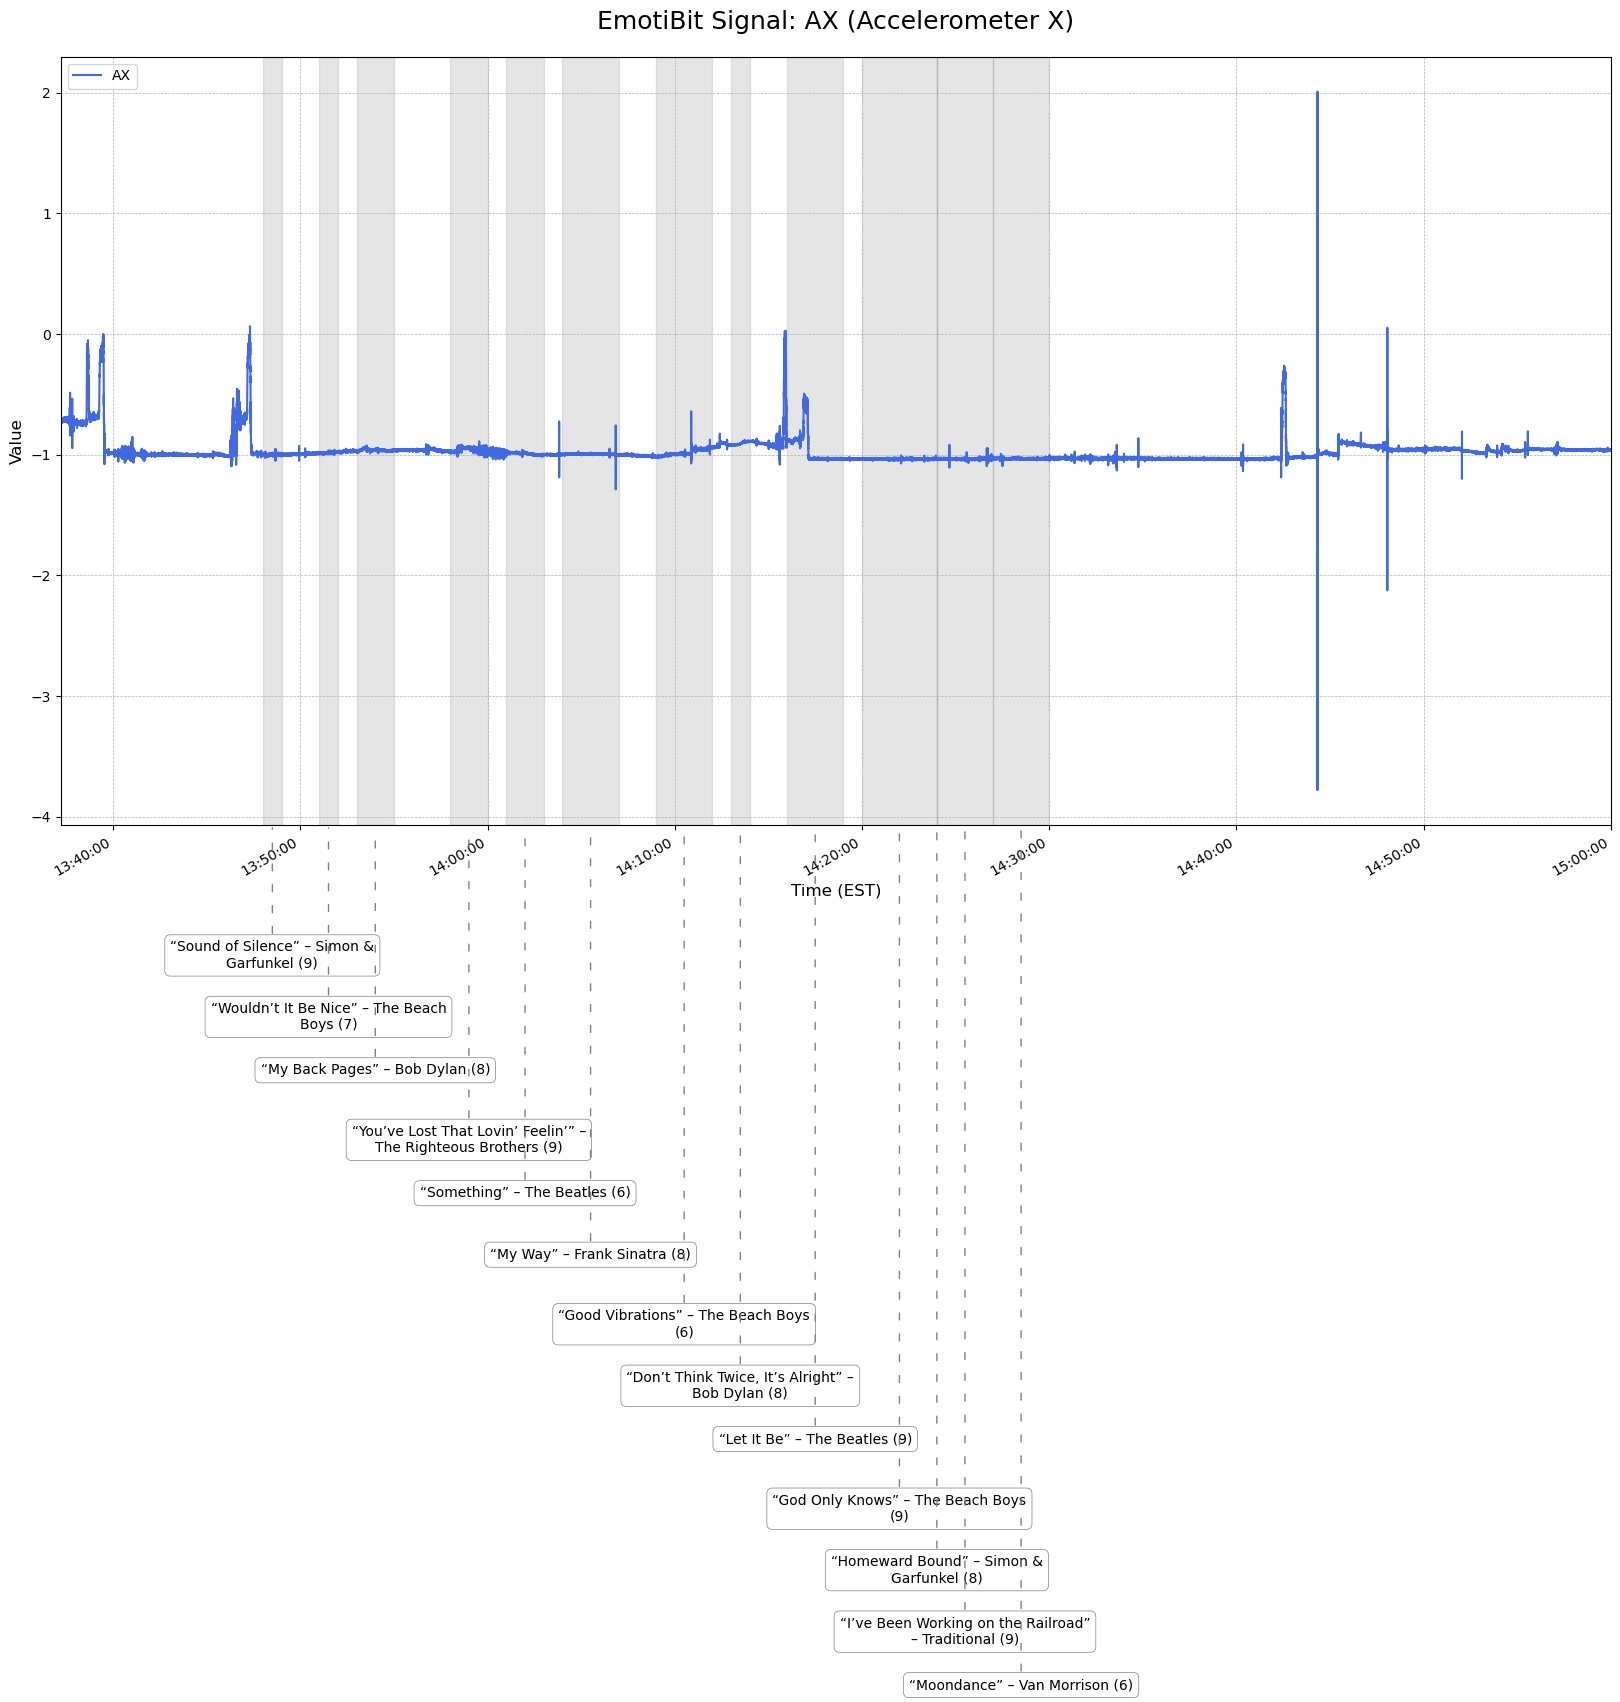

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/AY_plot.png


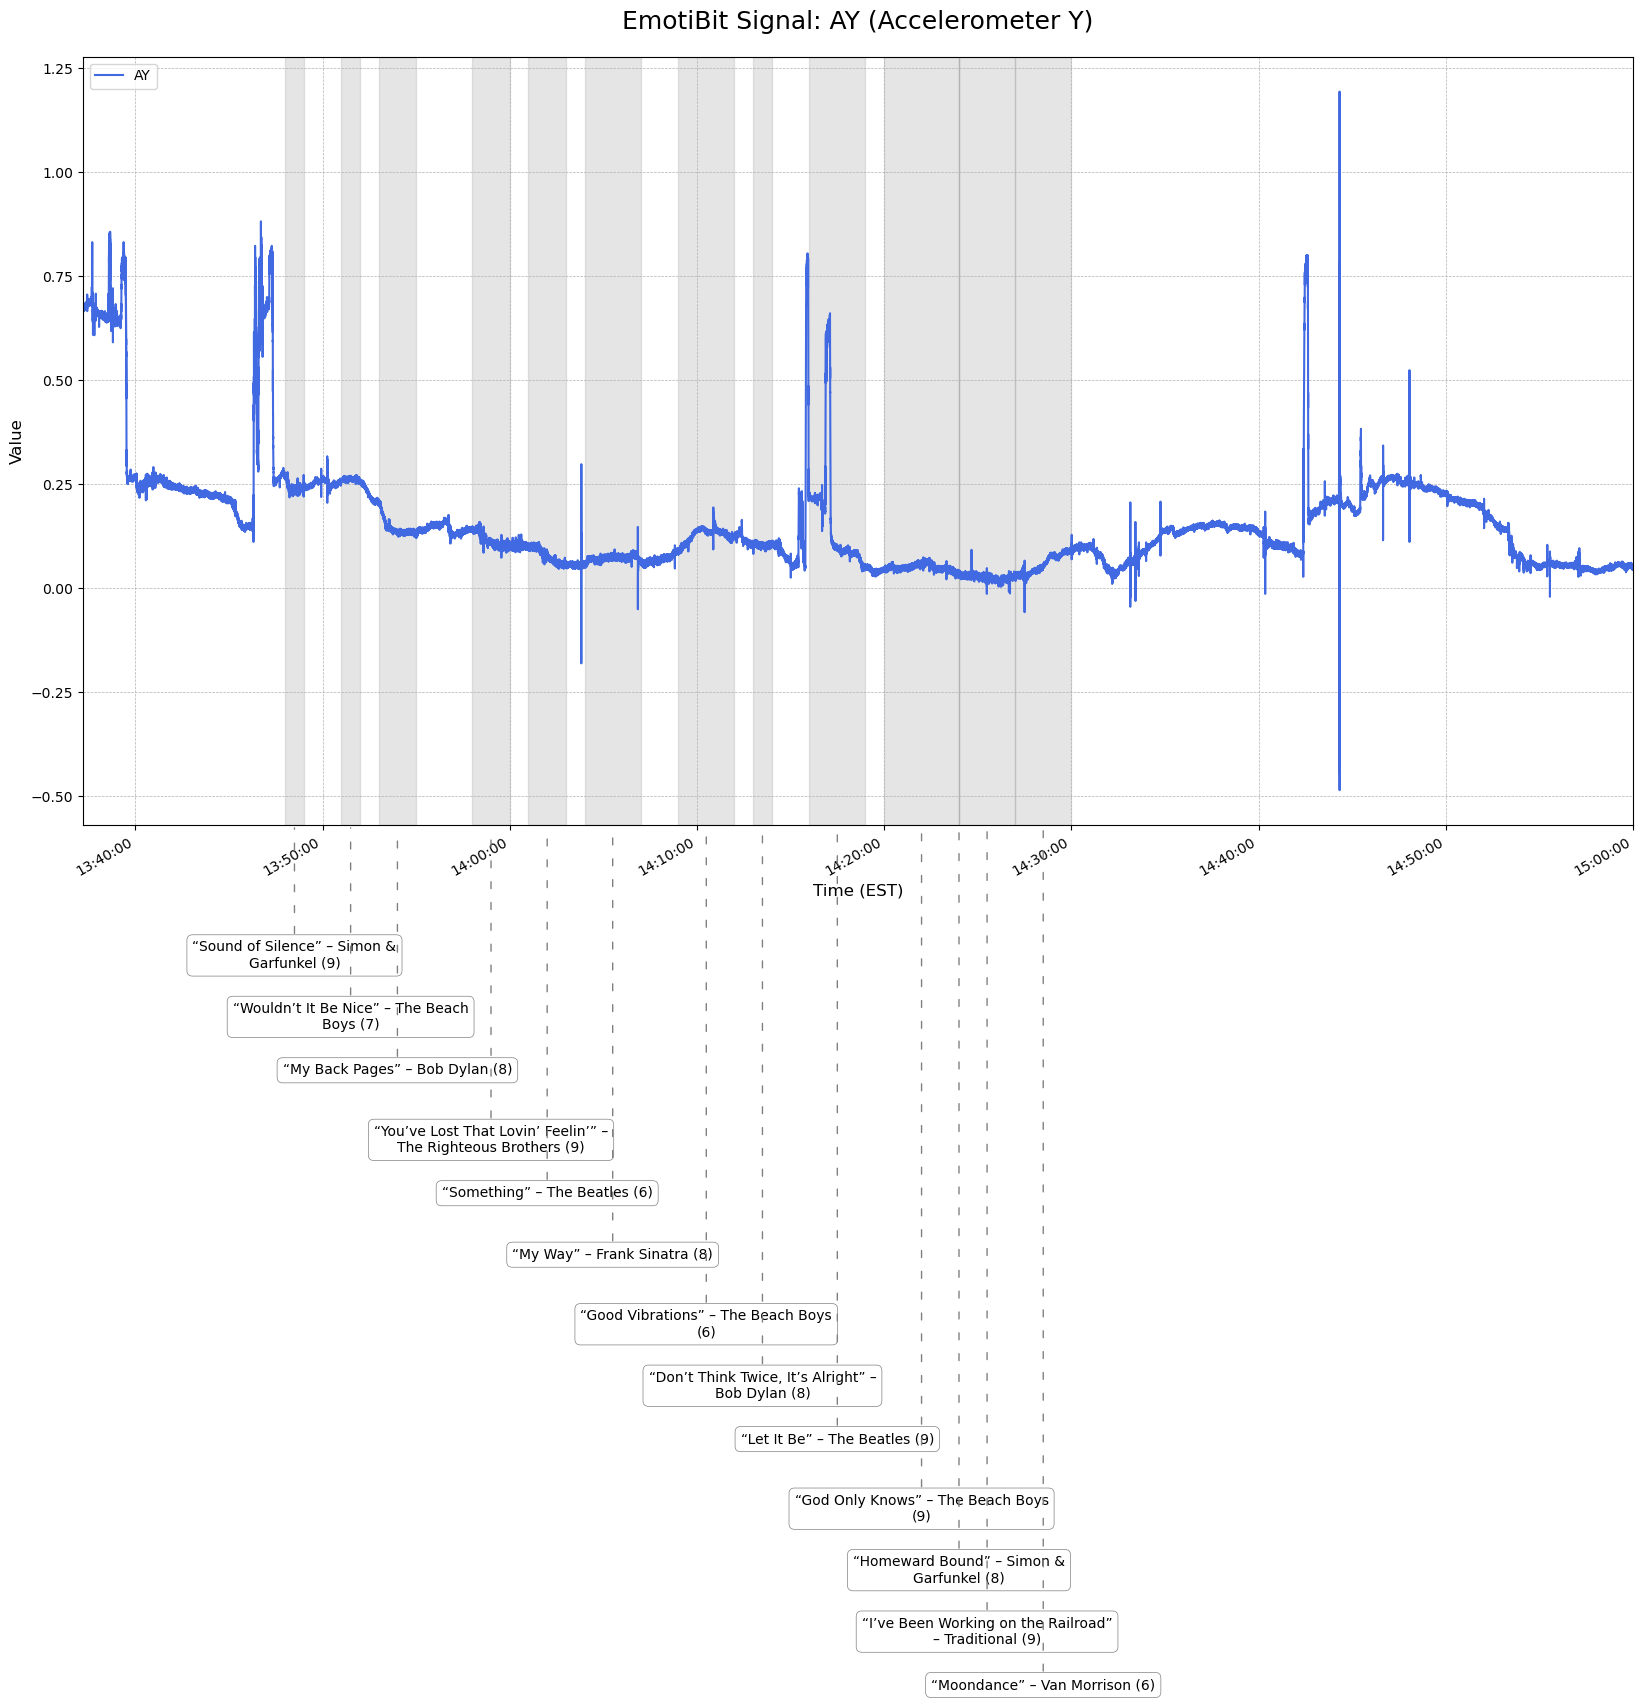

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/AZ_plot.png


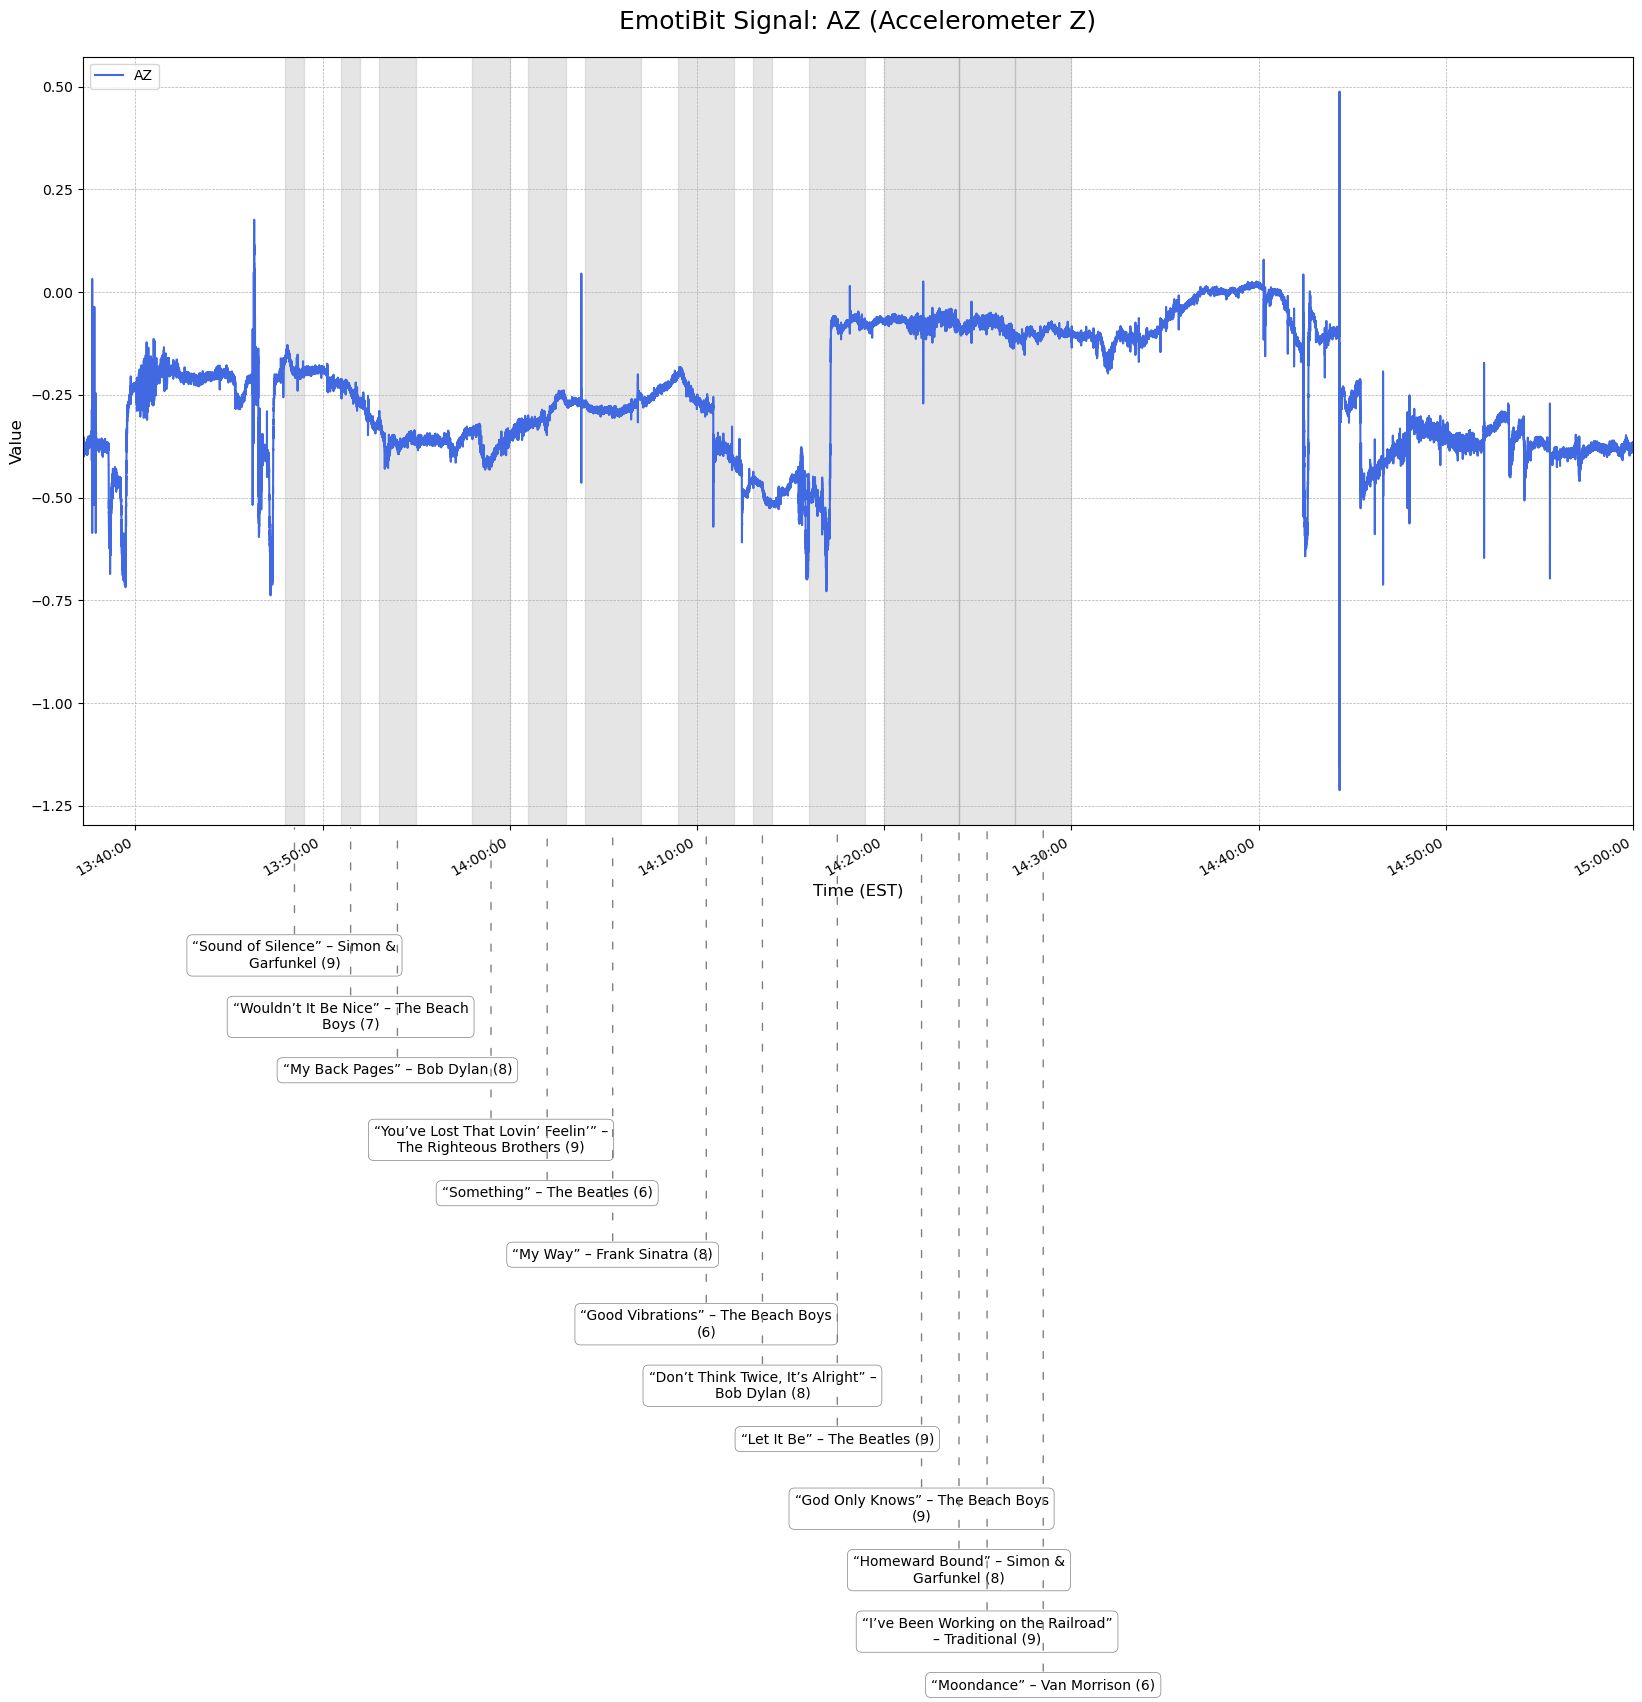

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/GX_plot.png


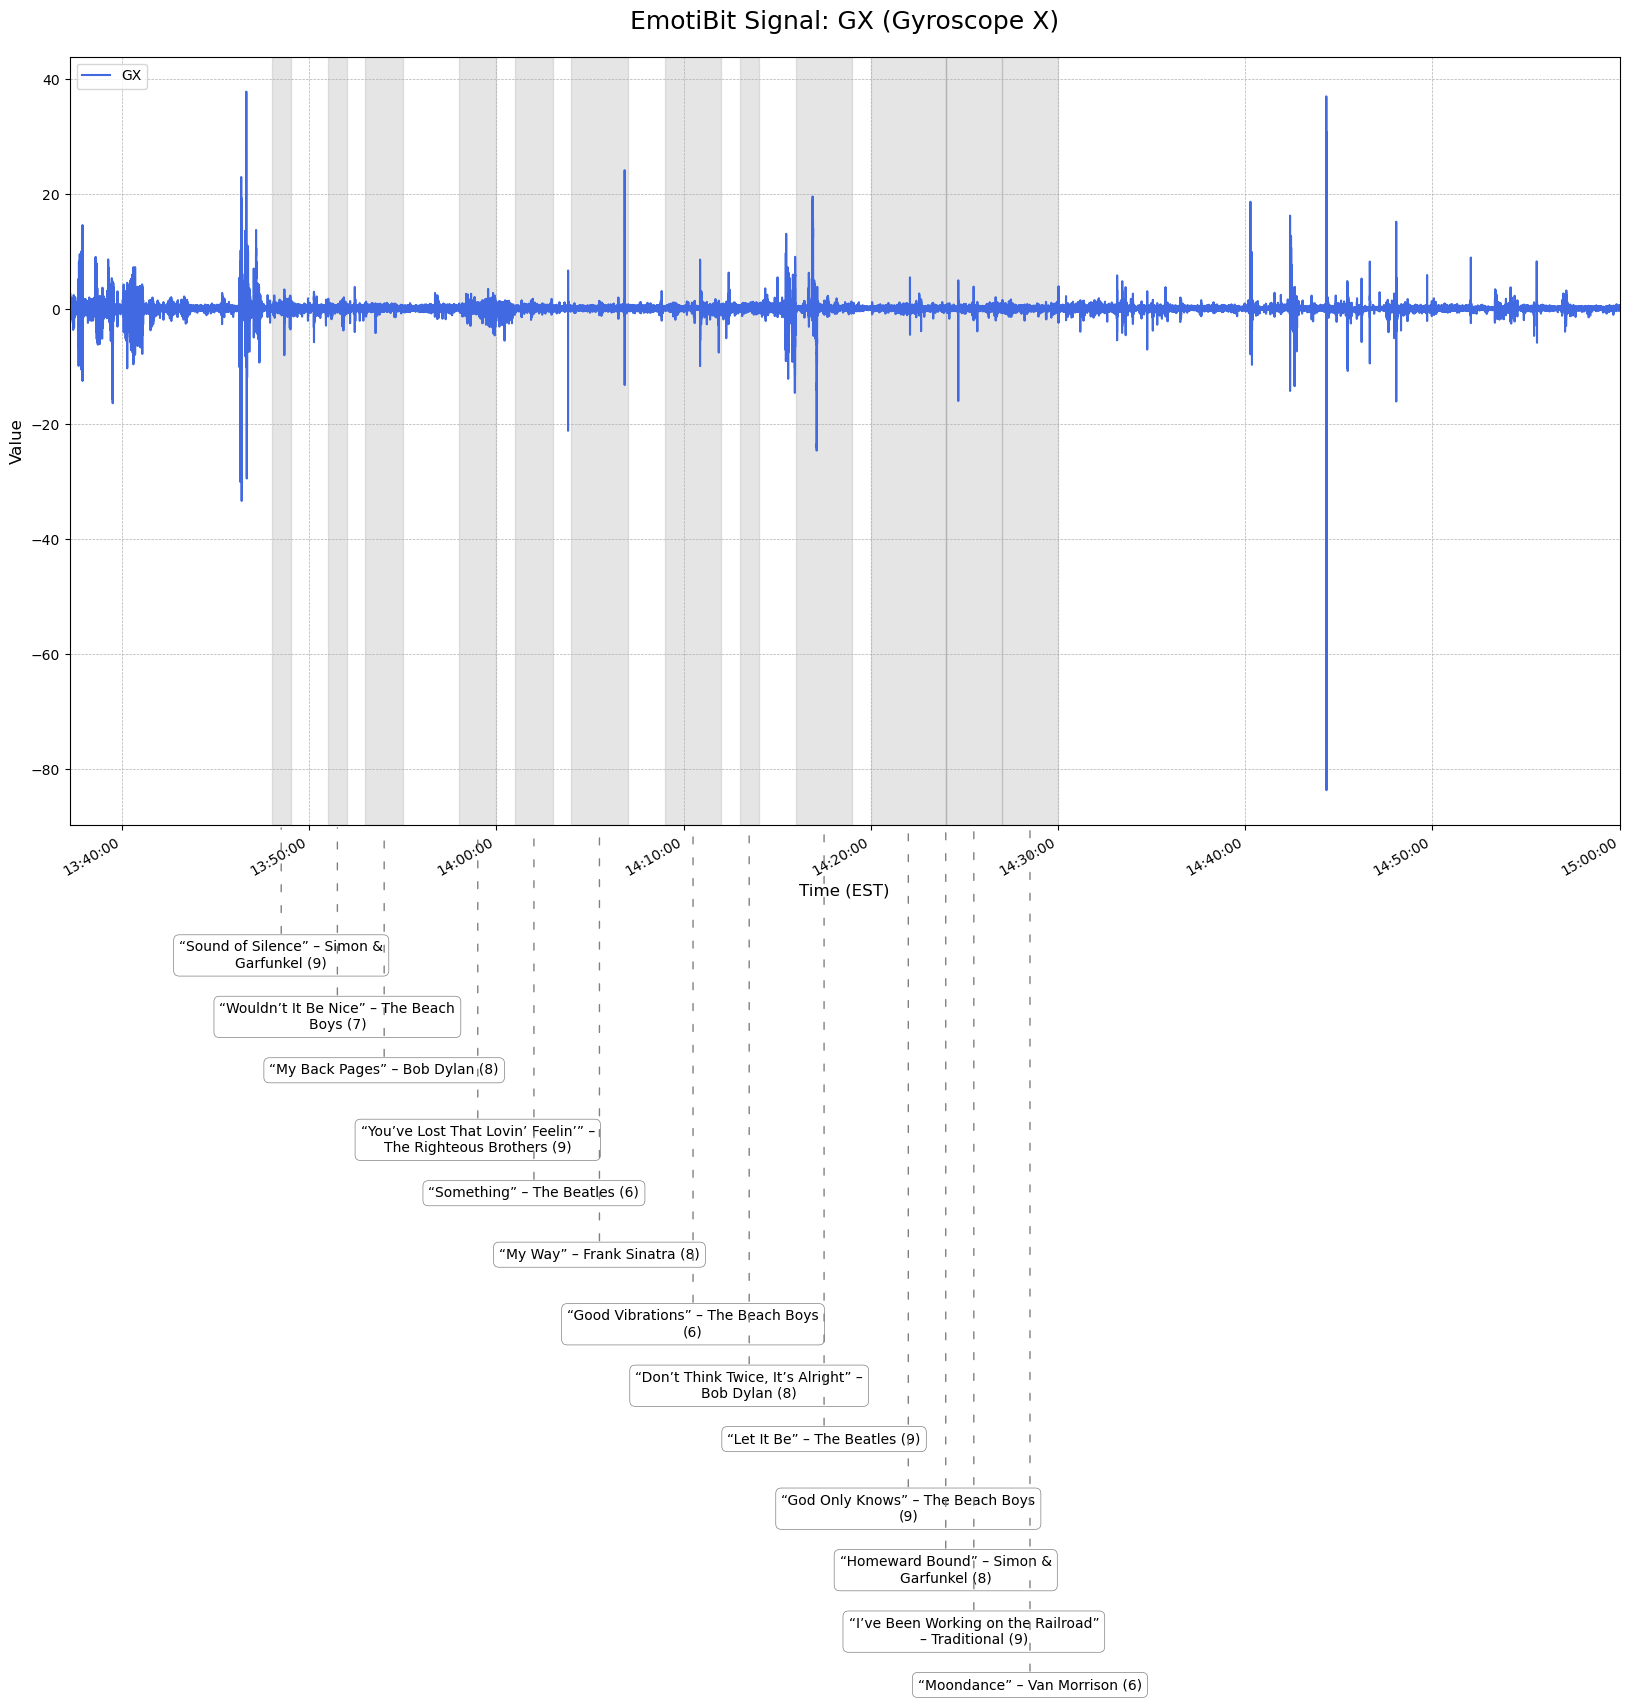

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/GY_plot.png


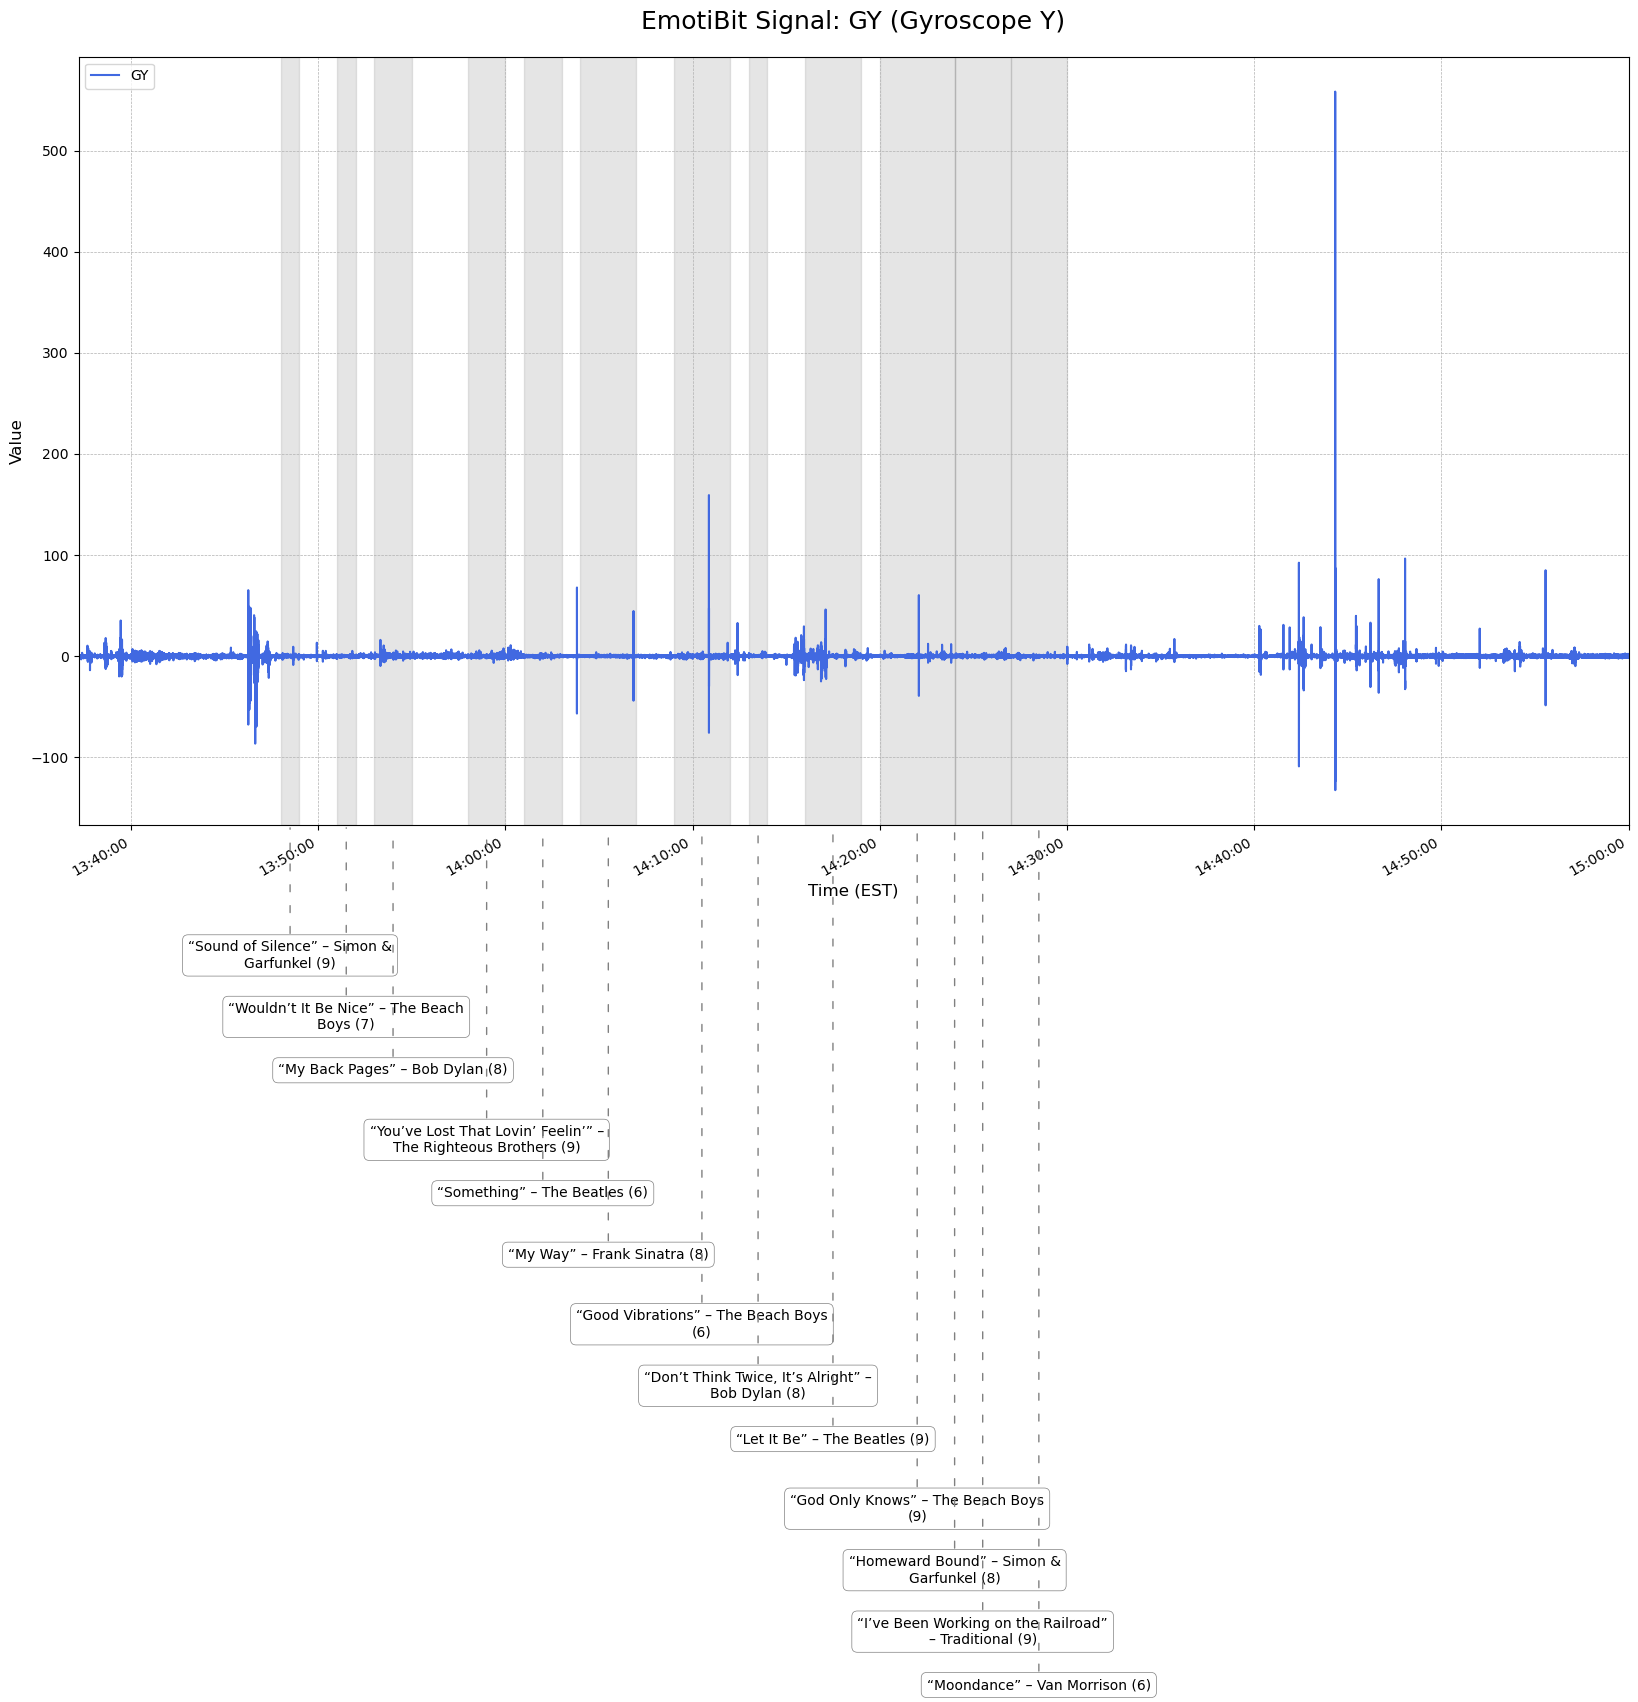

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/GZ_plot.png


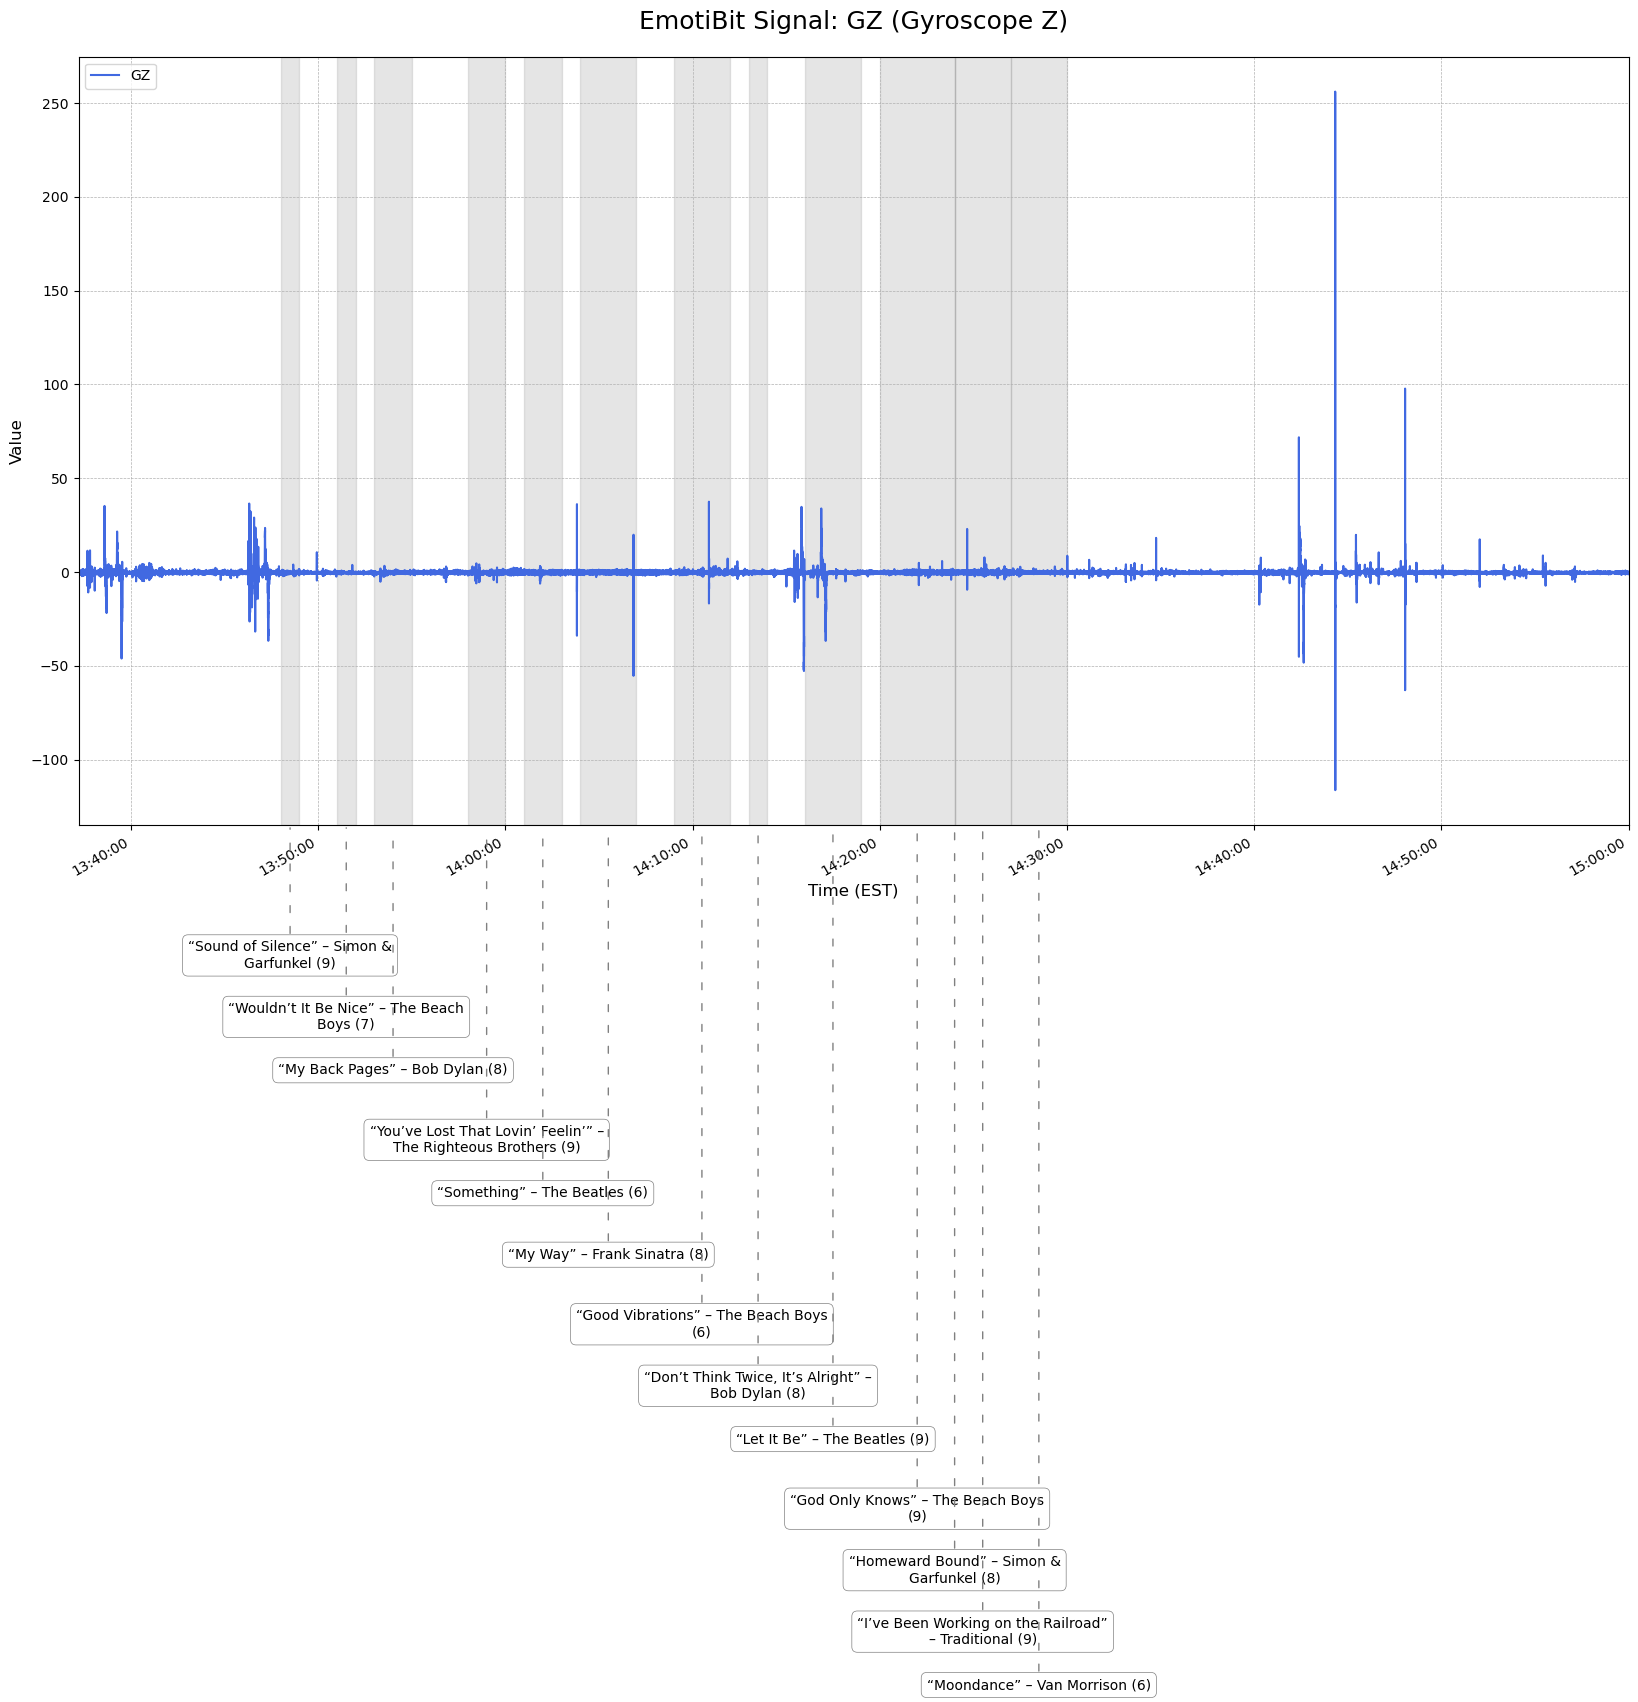

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/EA_plot.png


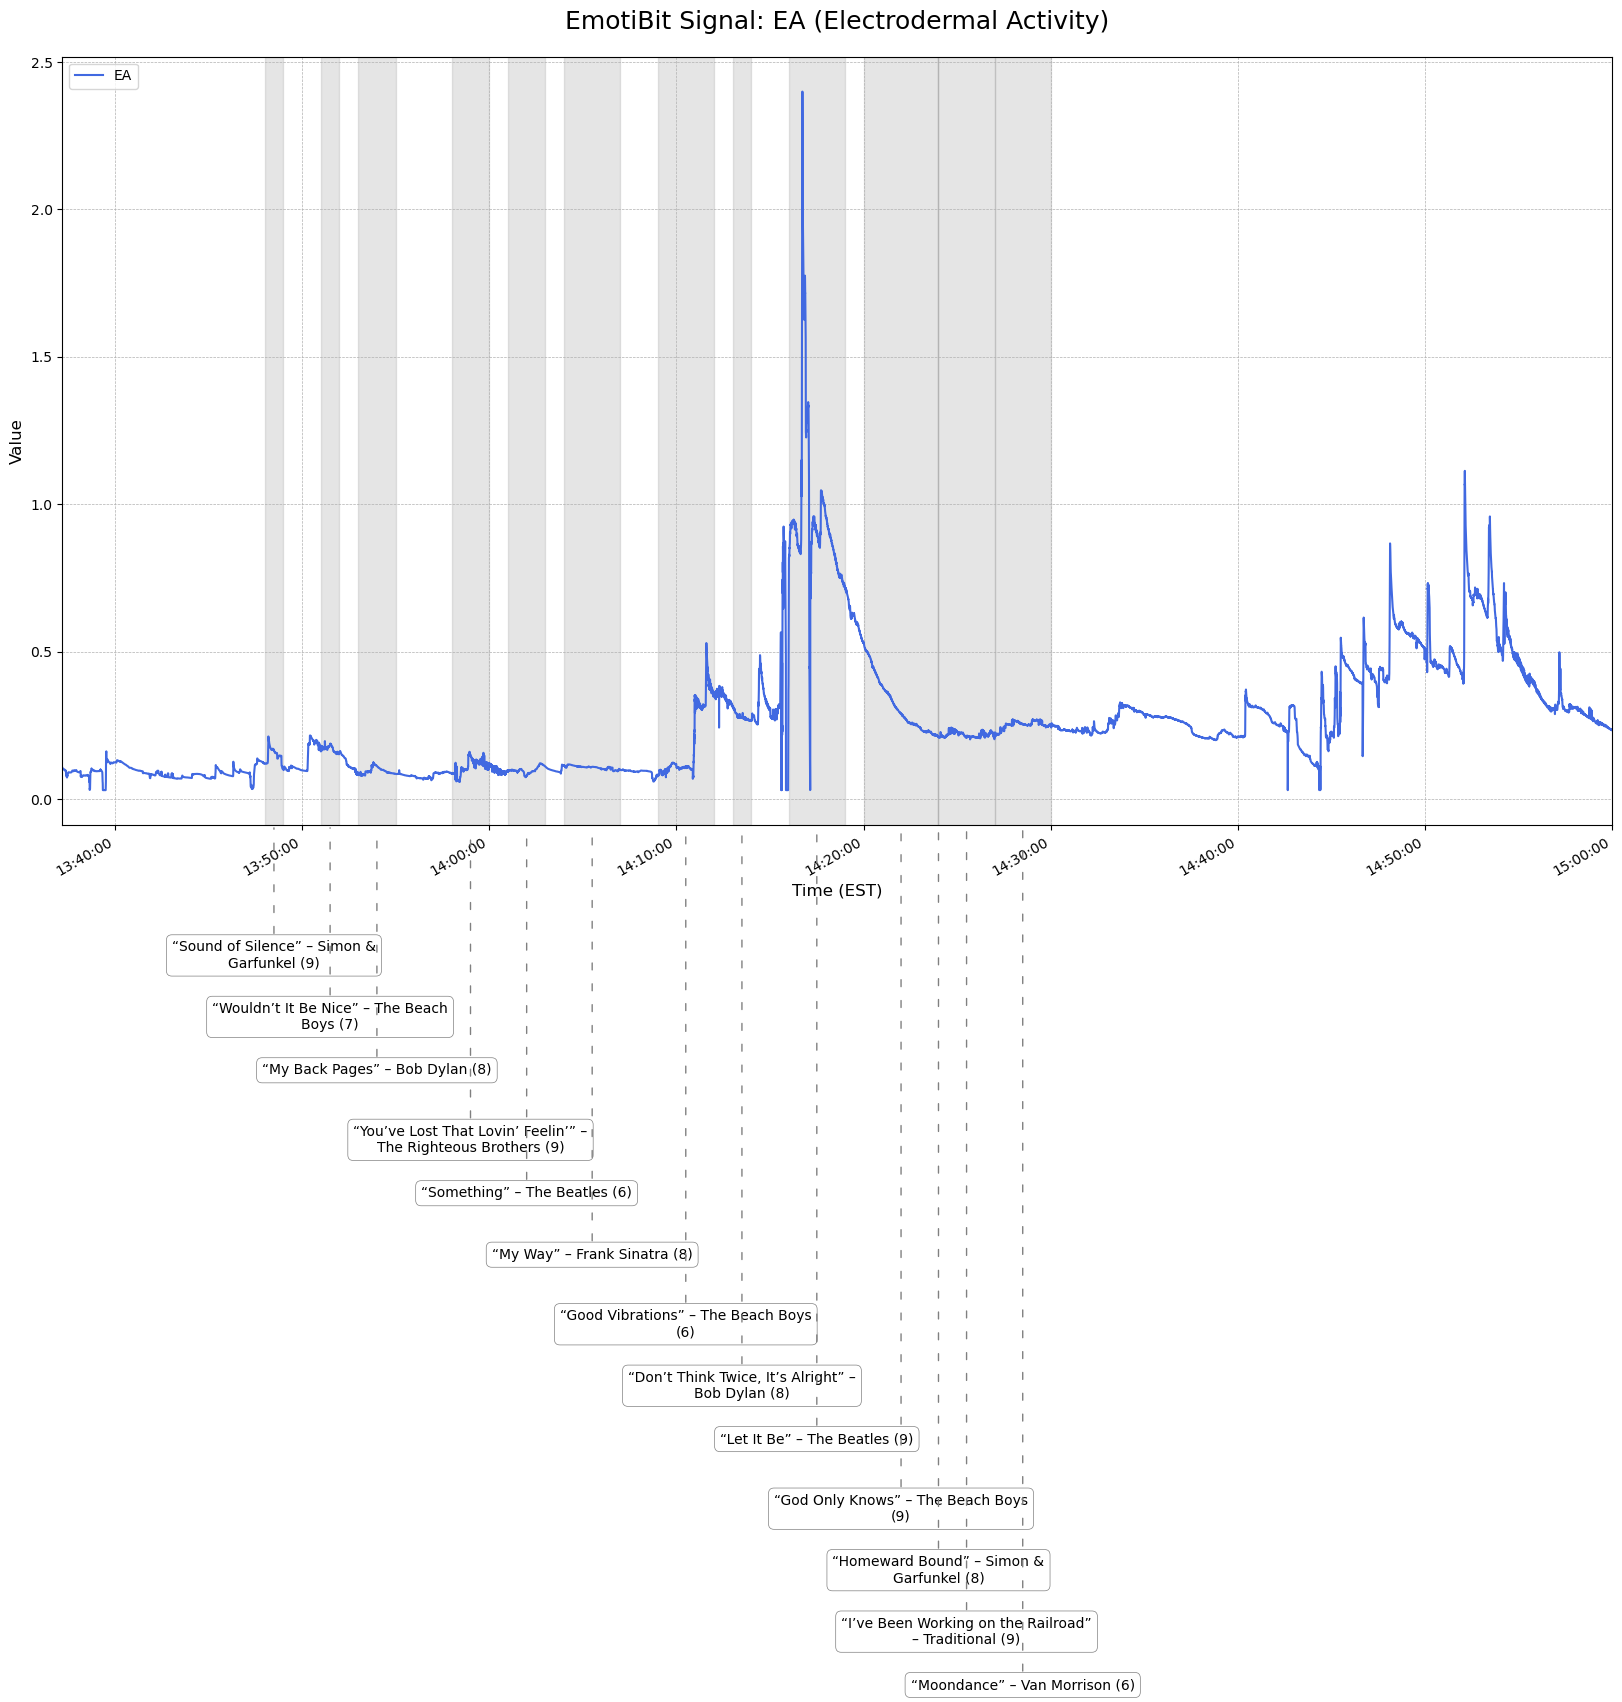

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/EL_plot.png


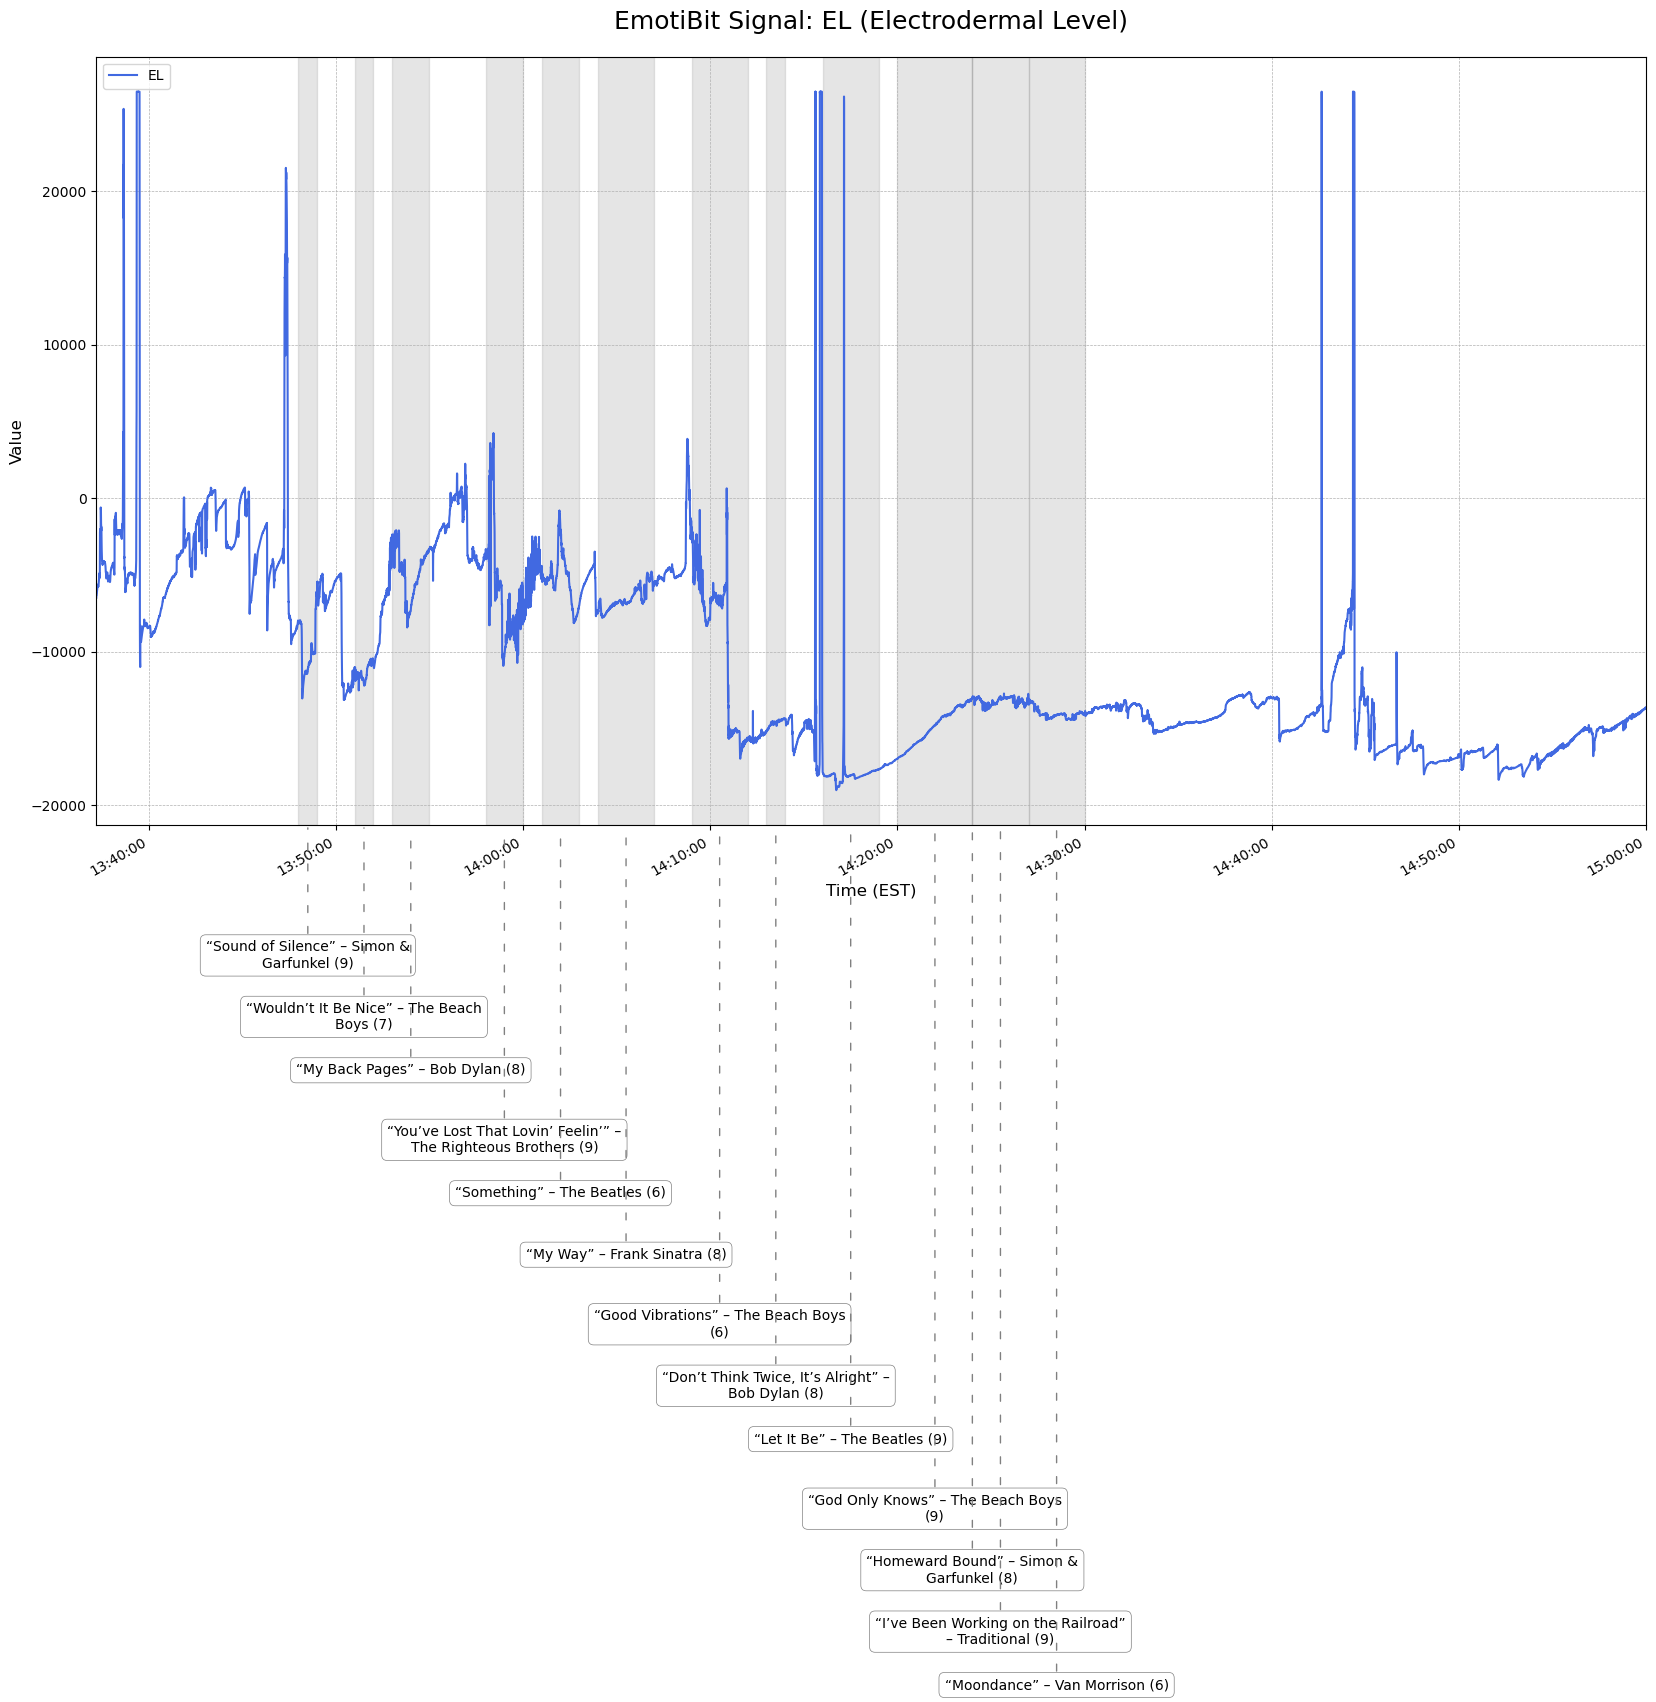

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/SF_plot.png


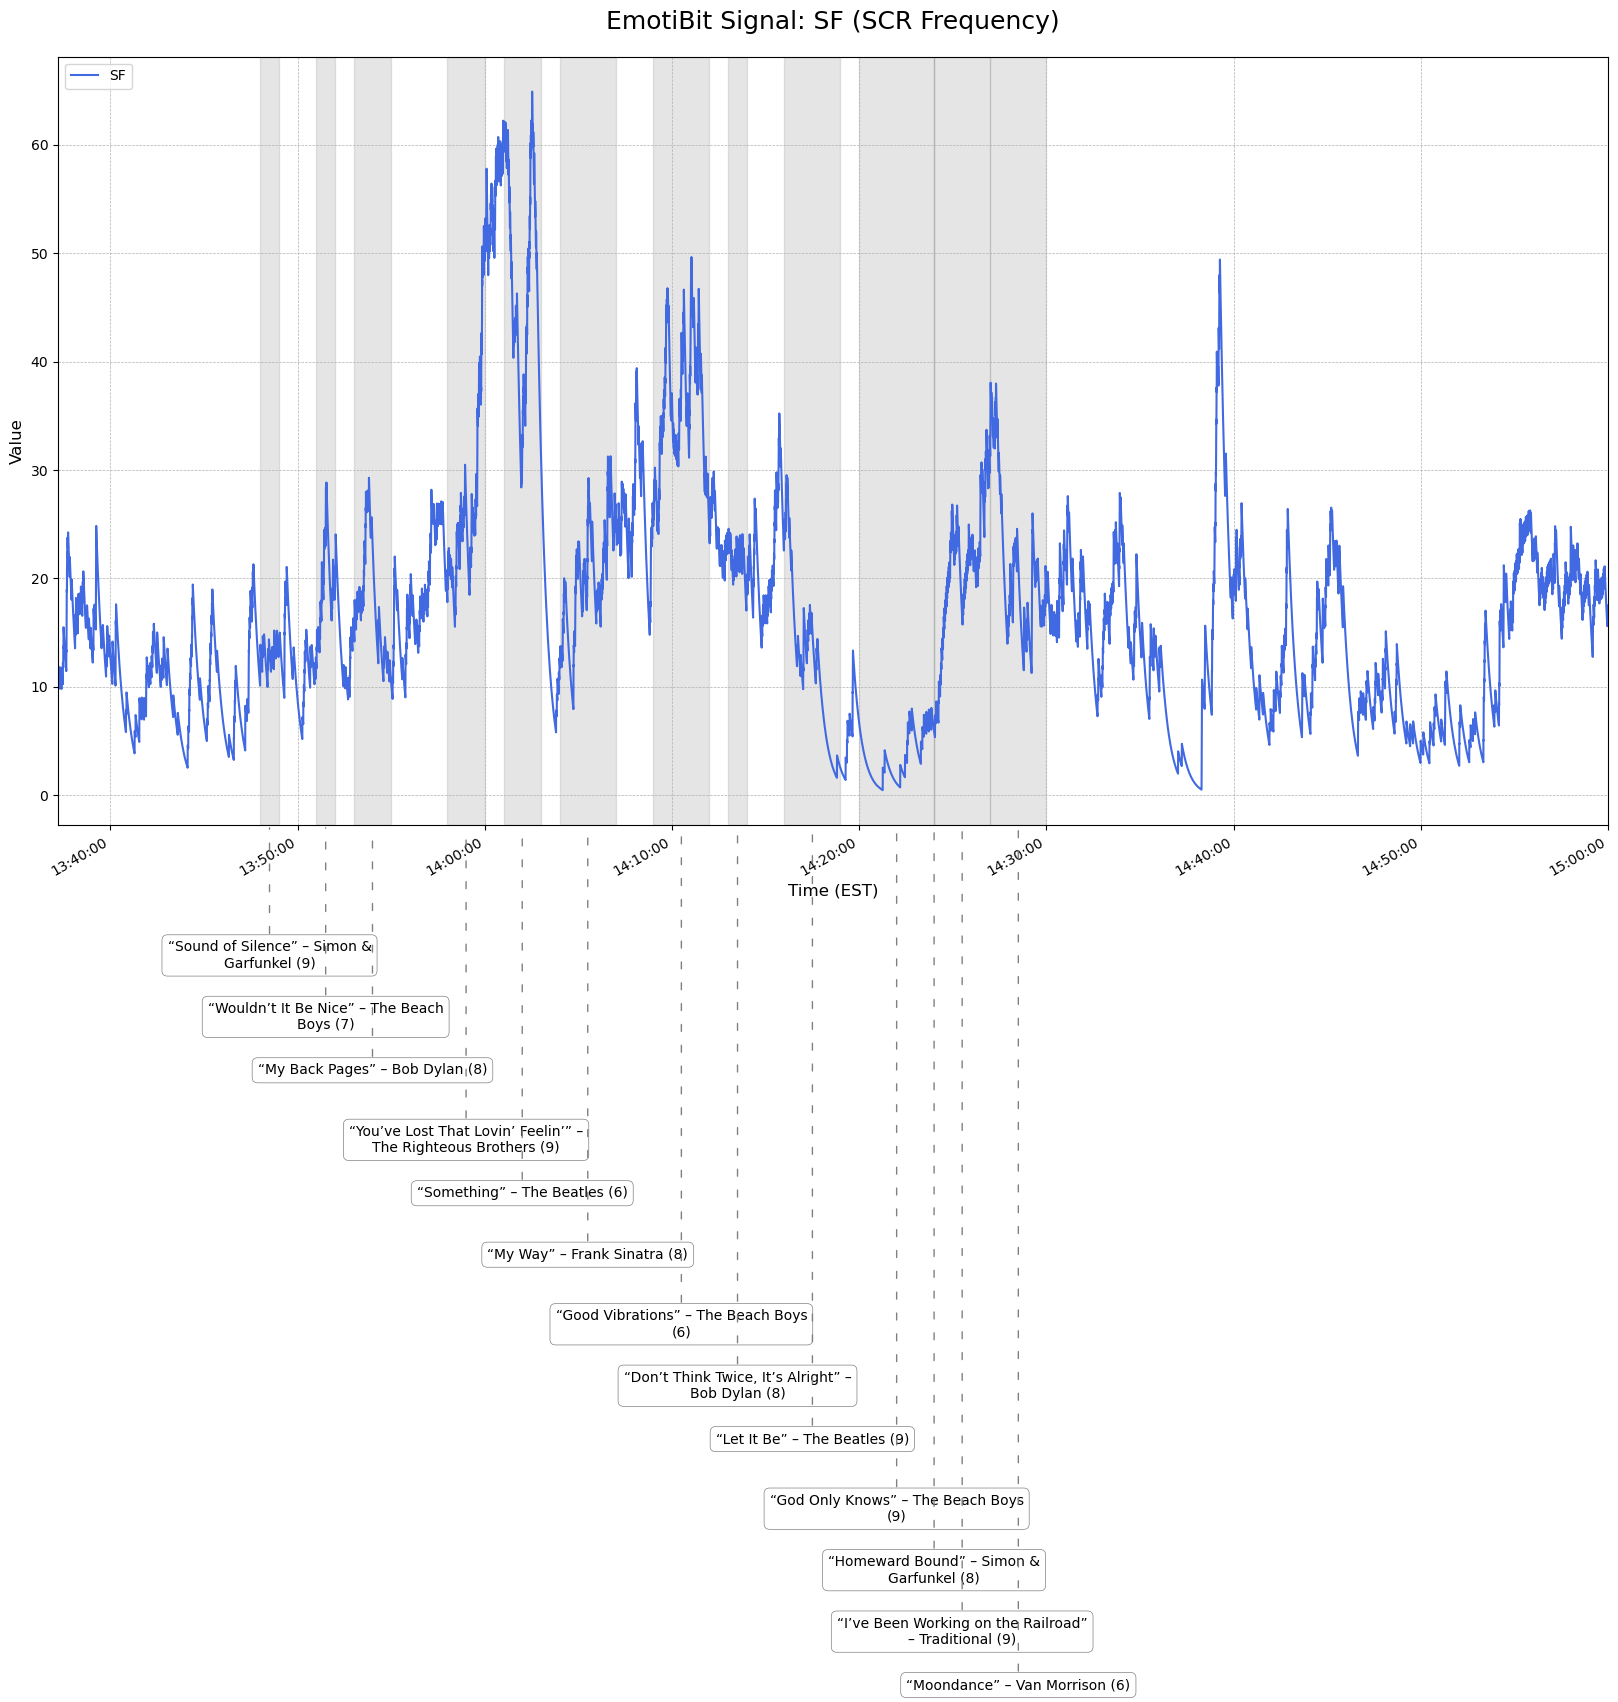

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/SA_plot.png


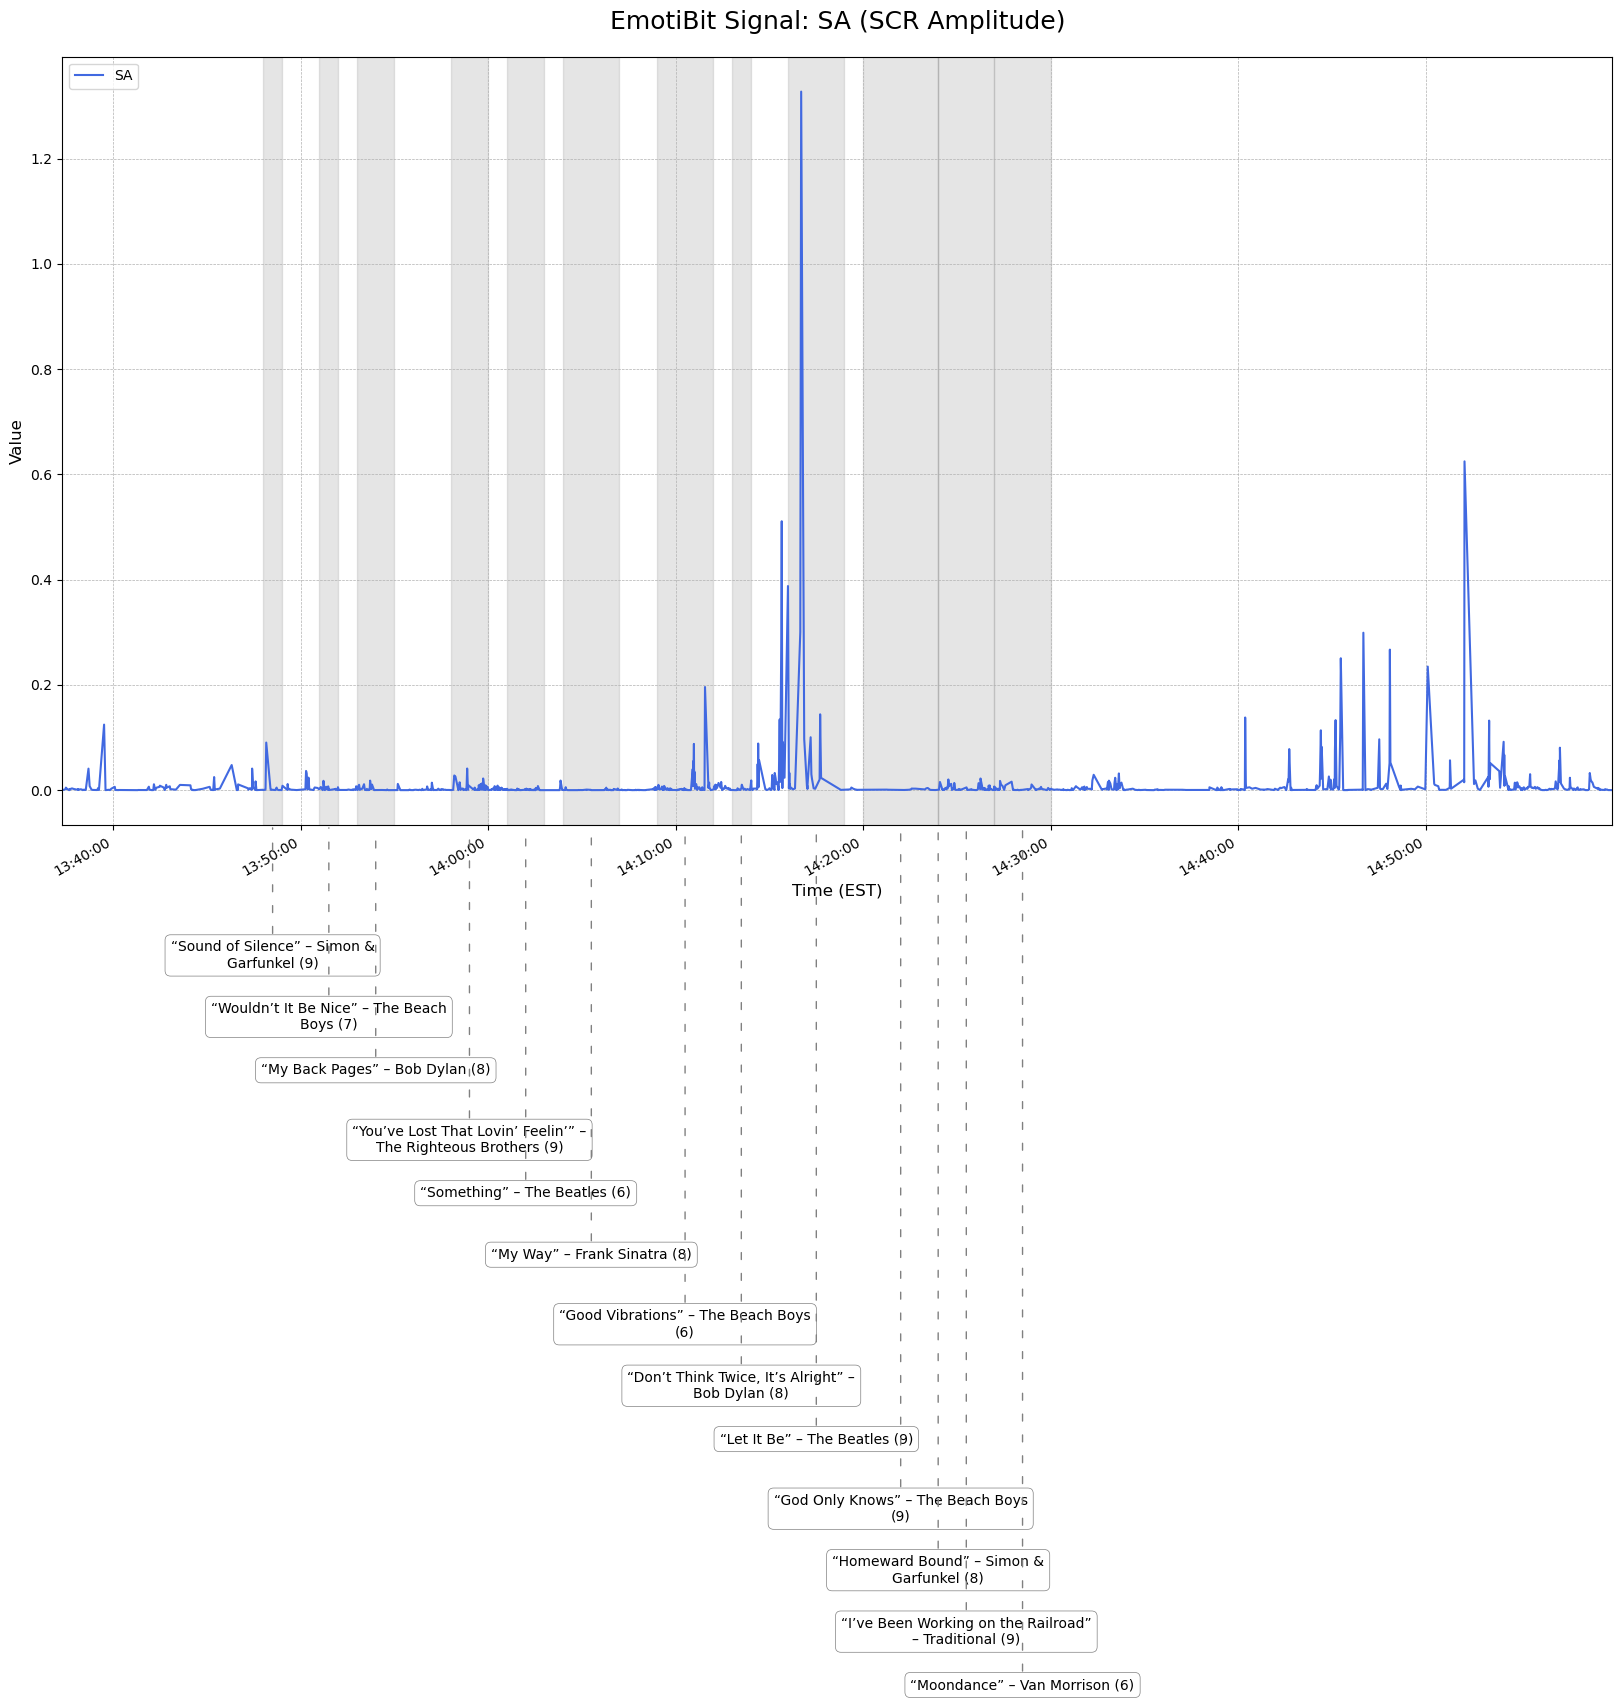

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/SR_plot.png


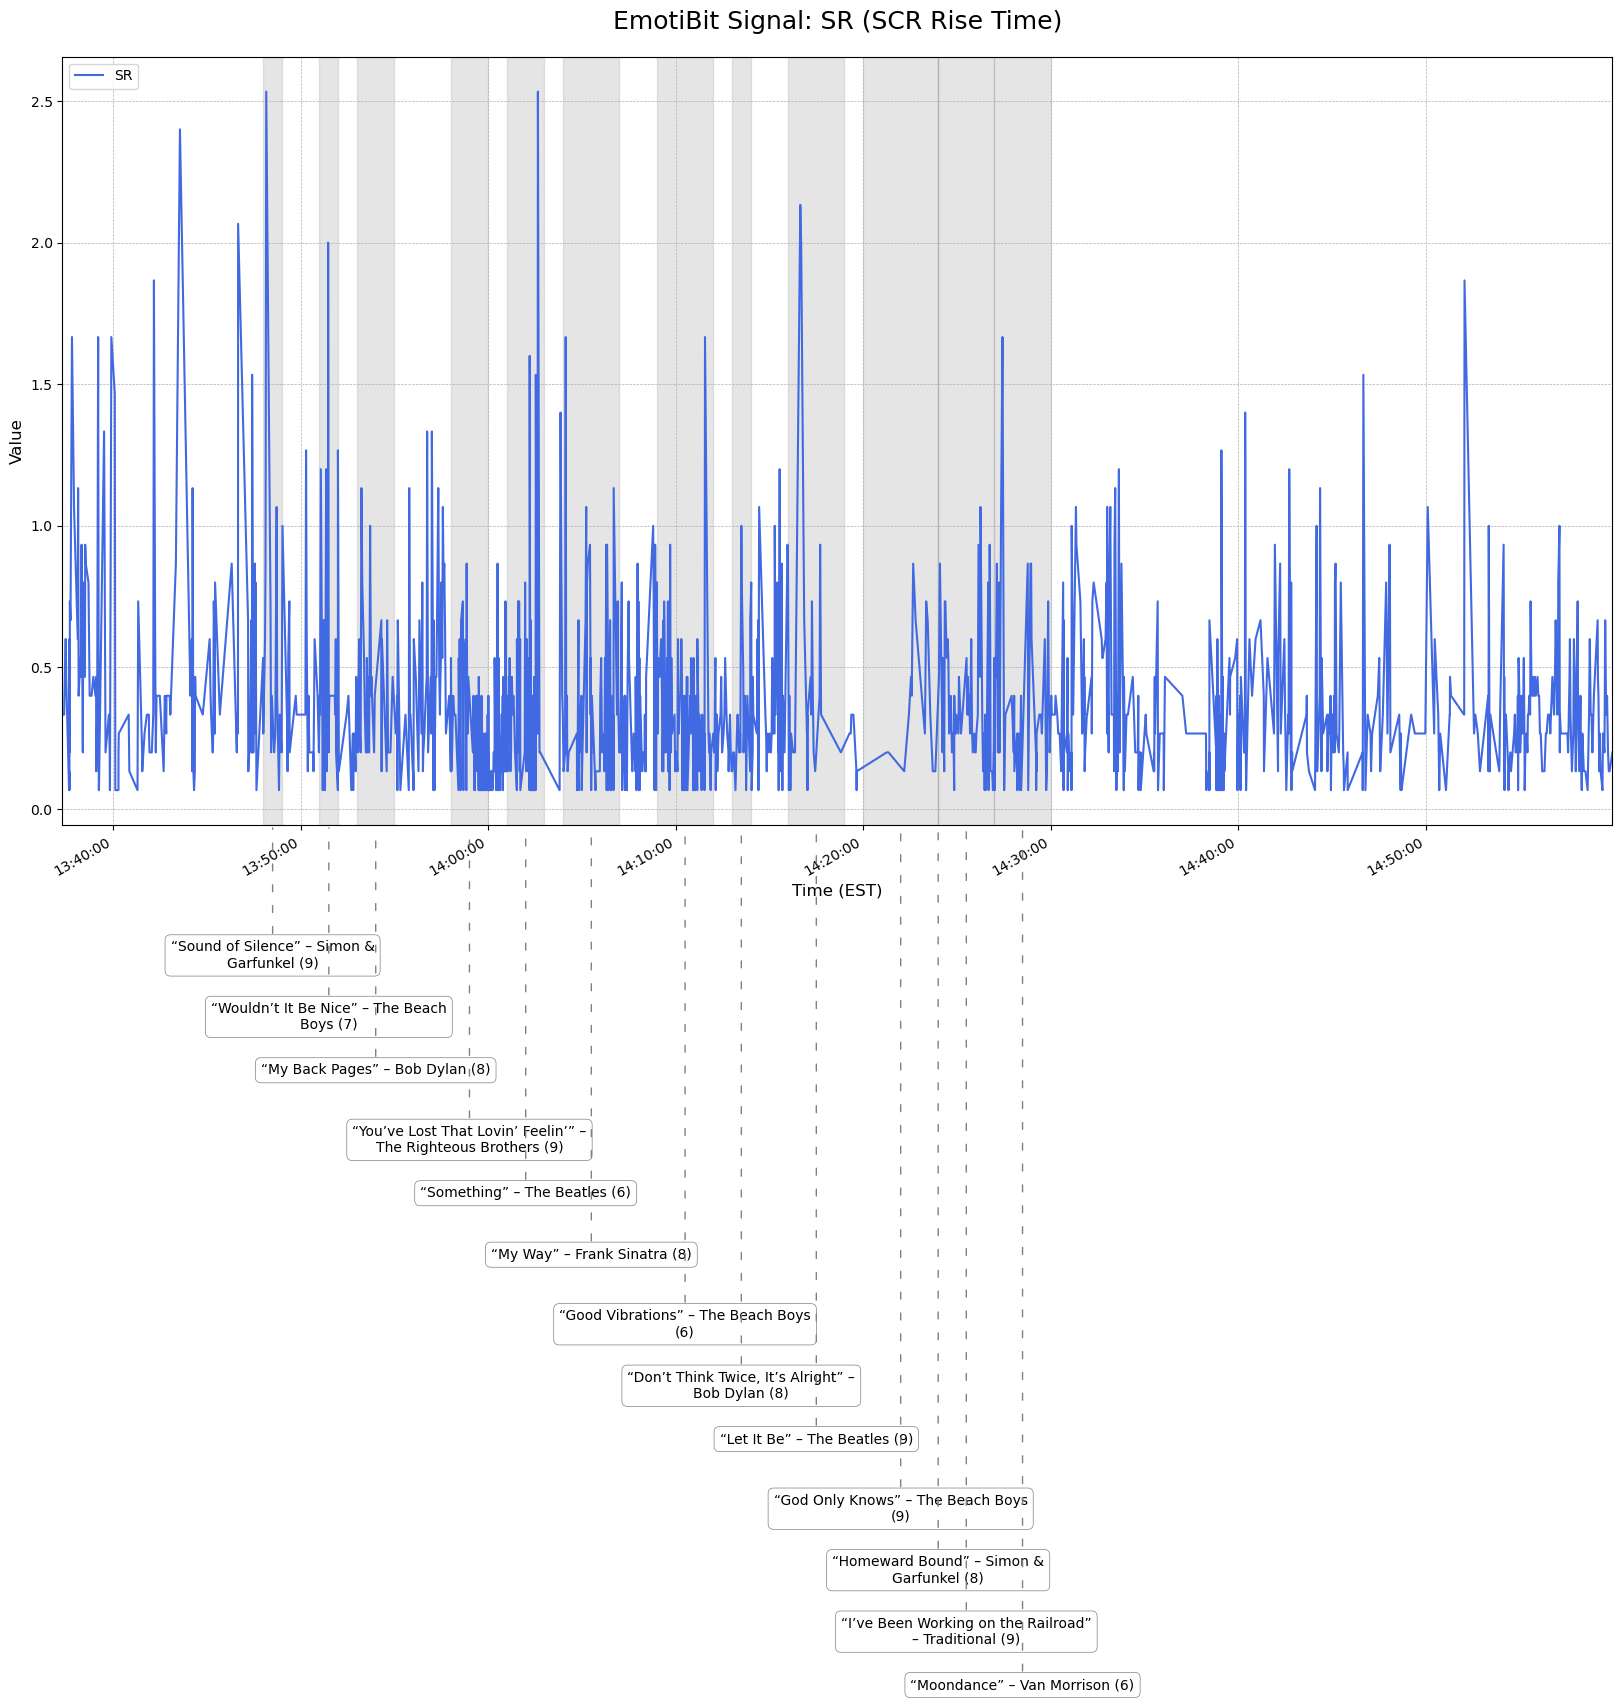

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/T1_plot.png


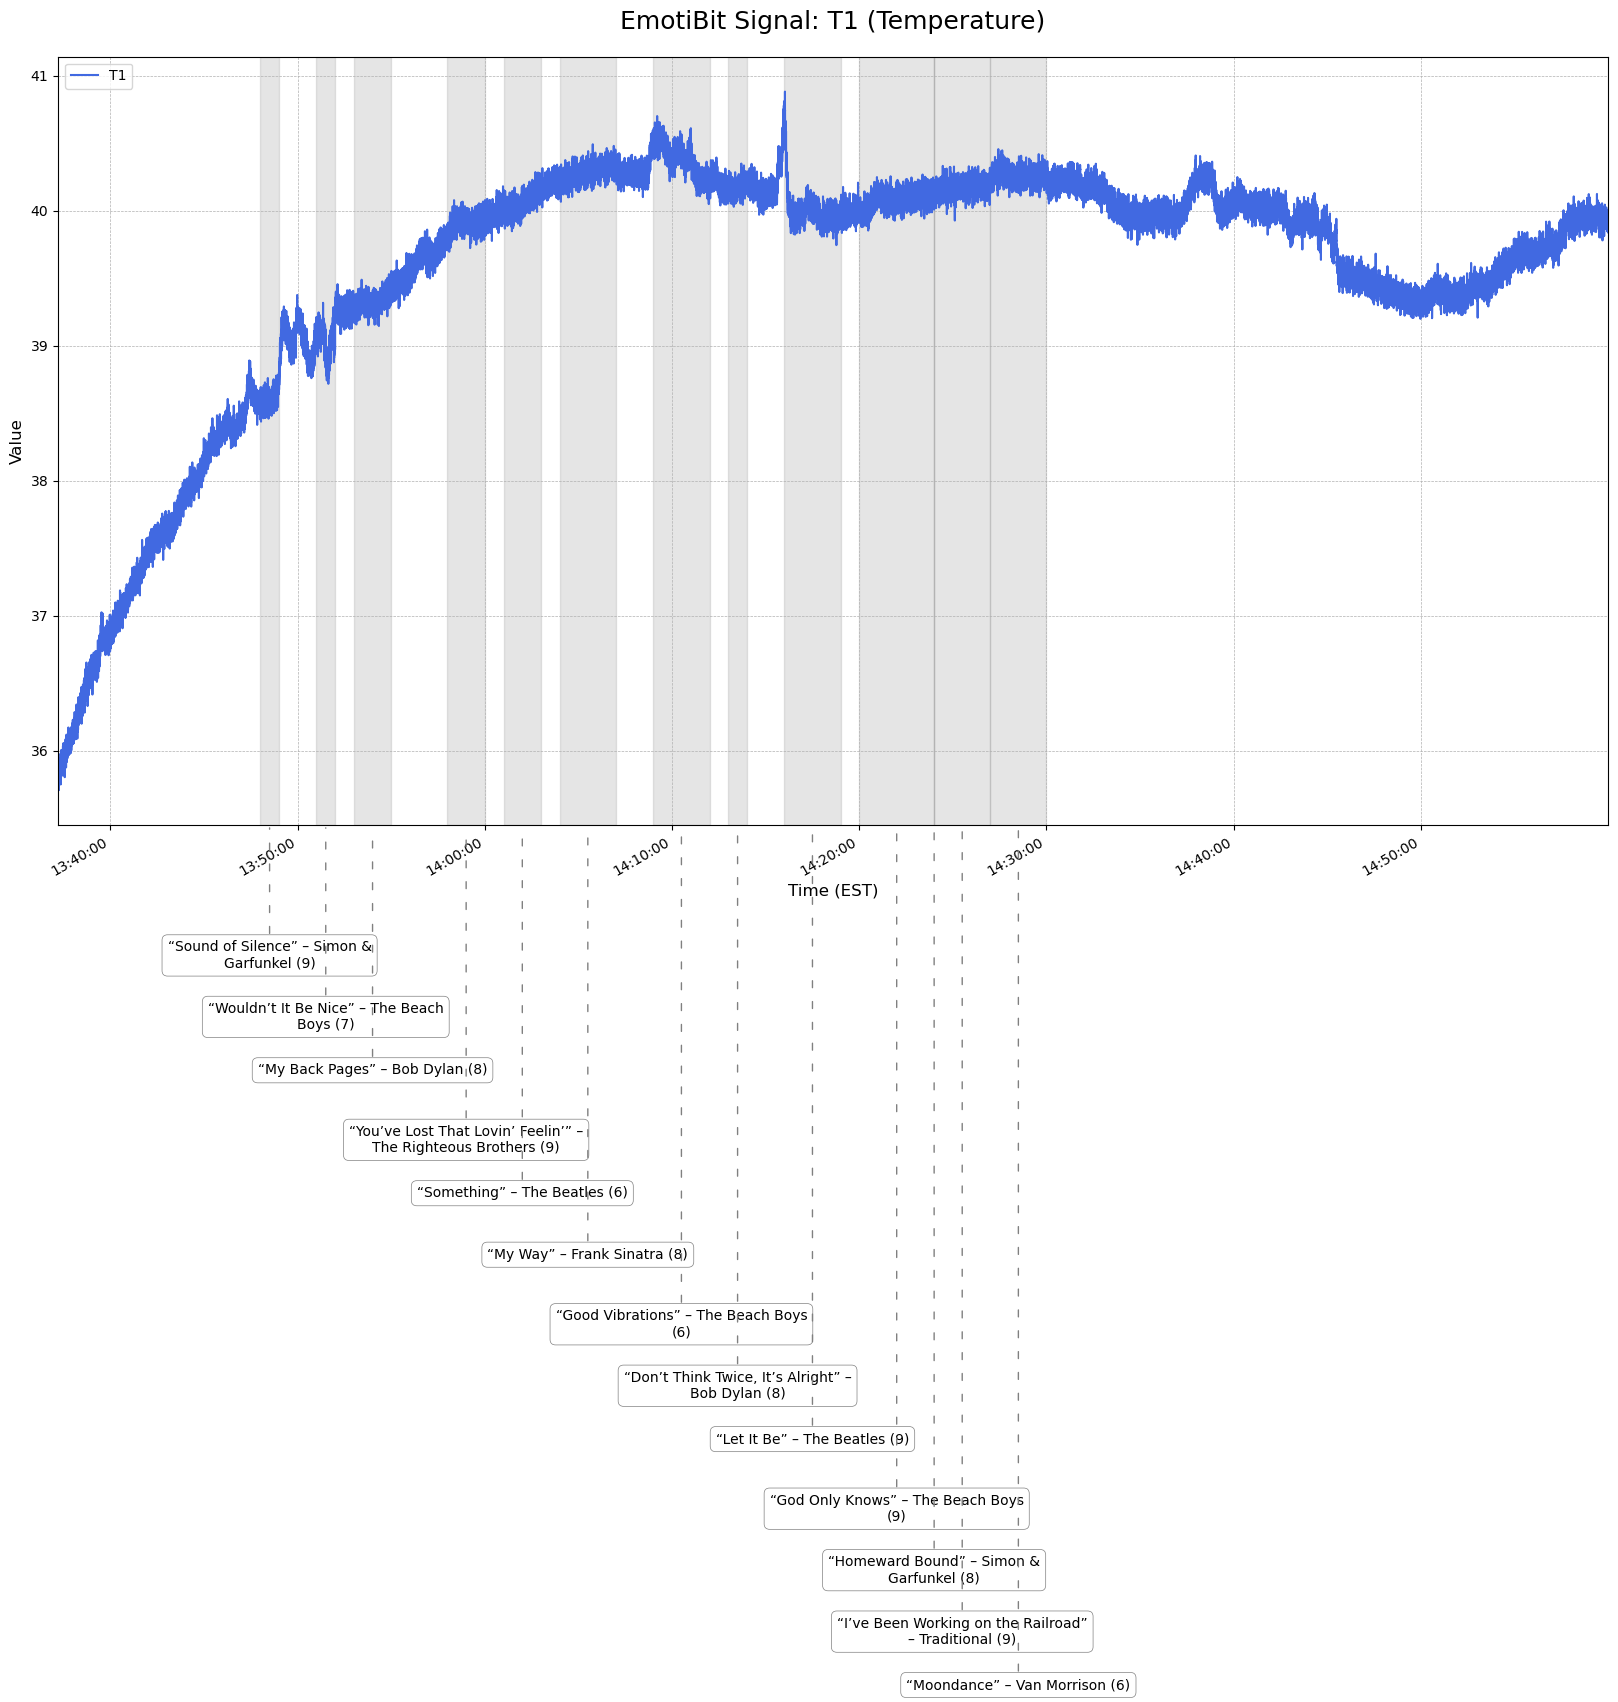

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/TH_plot.png


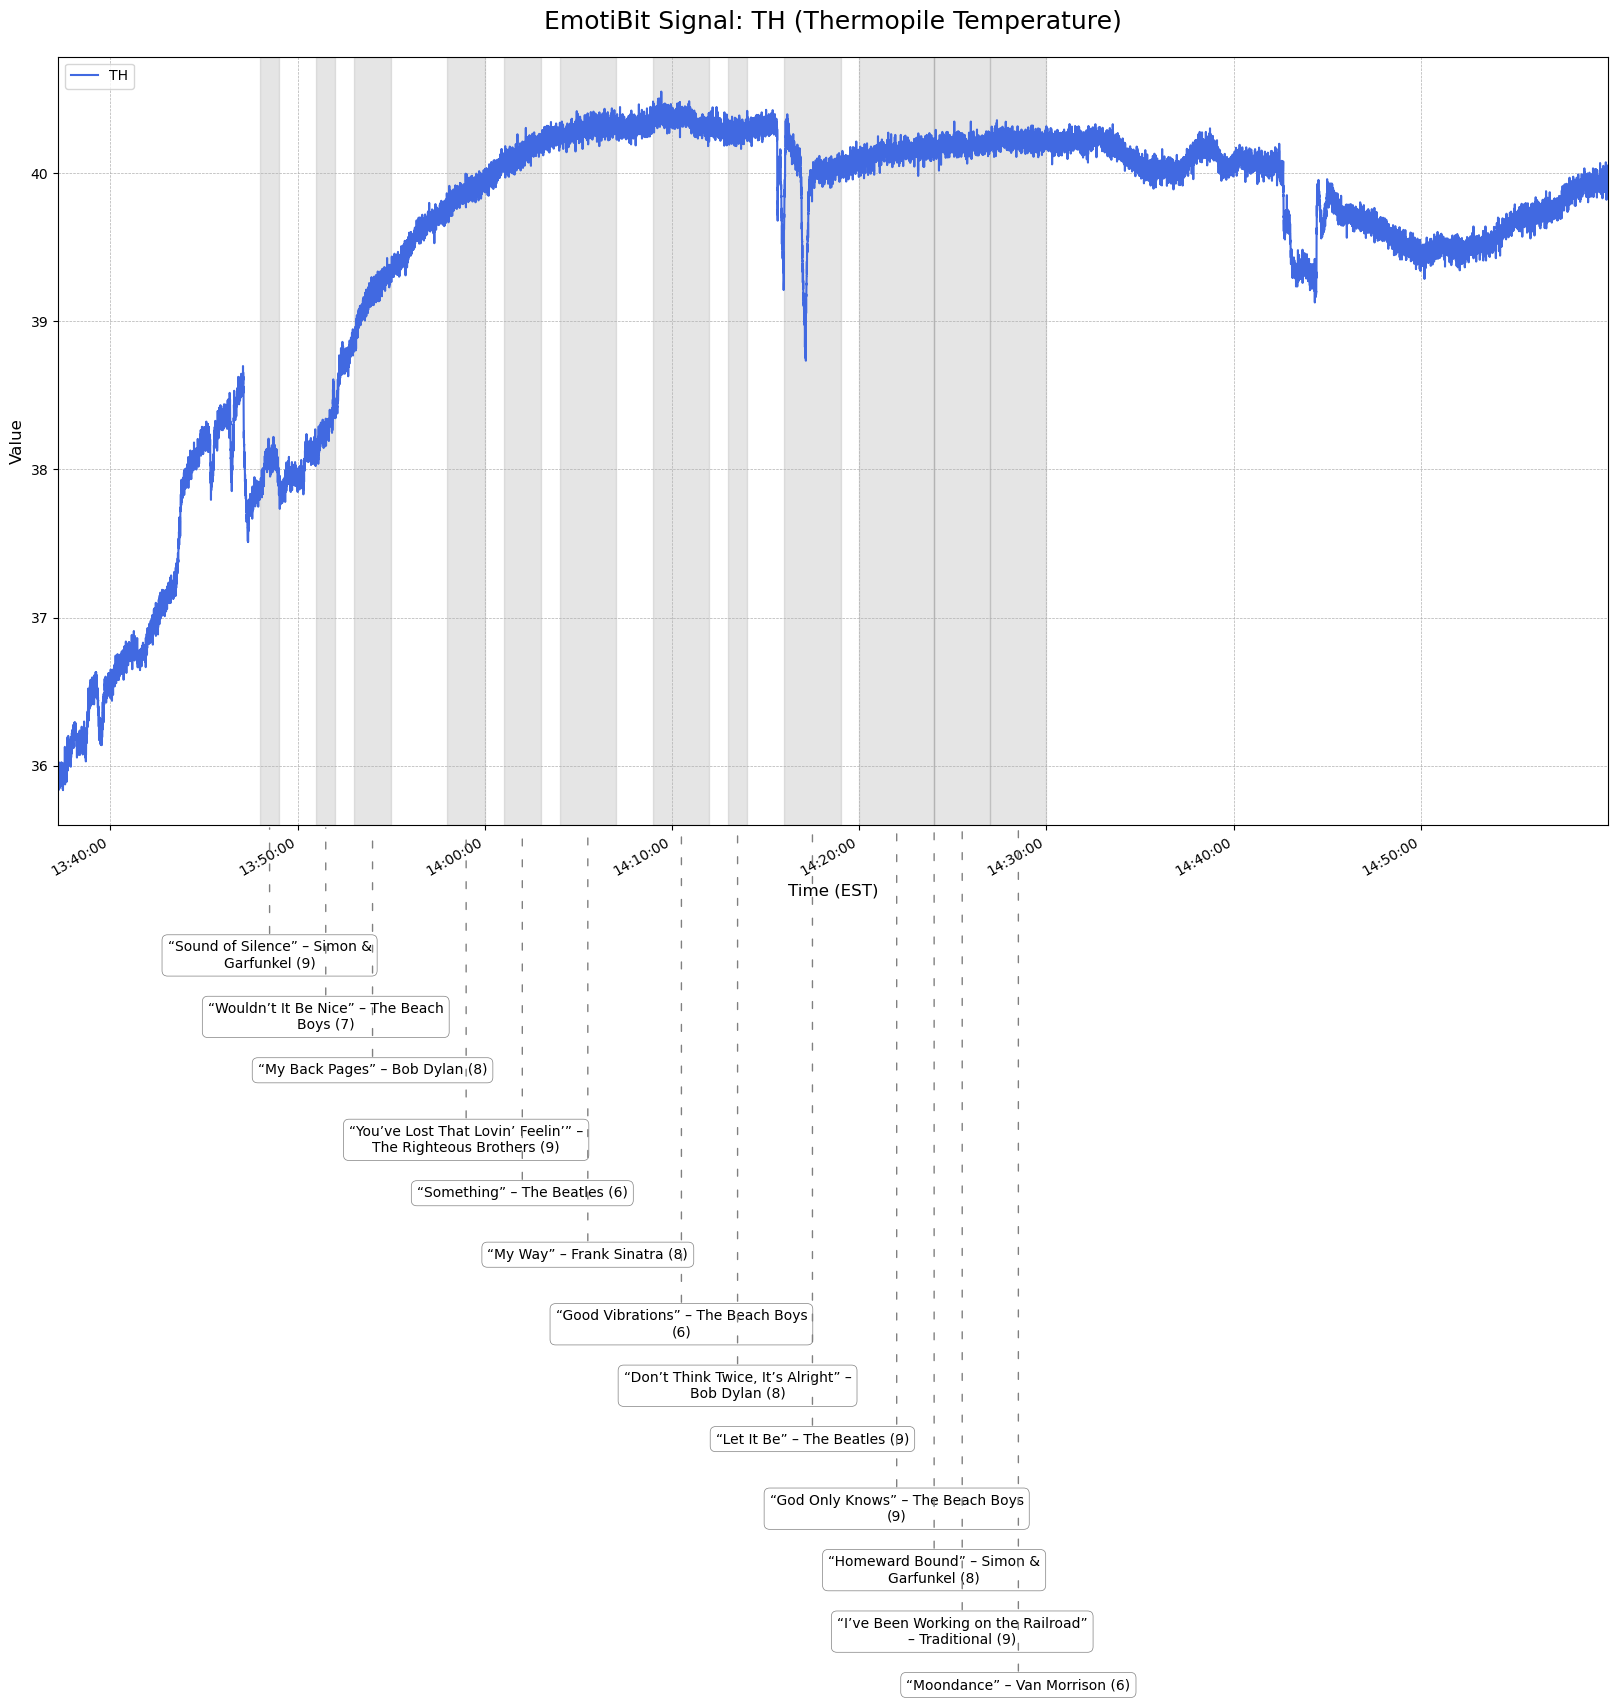

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/PI_plot.png


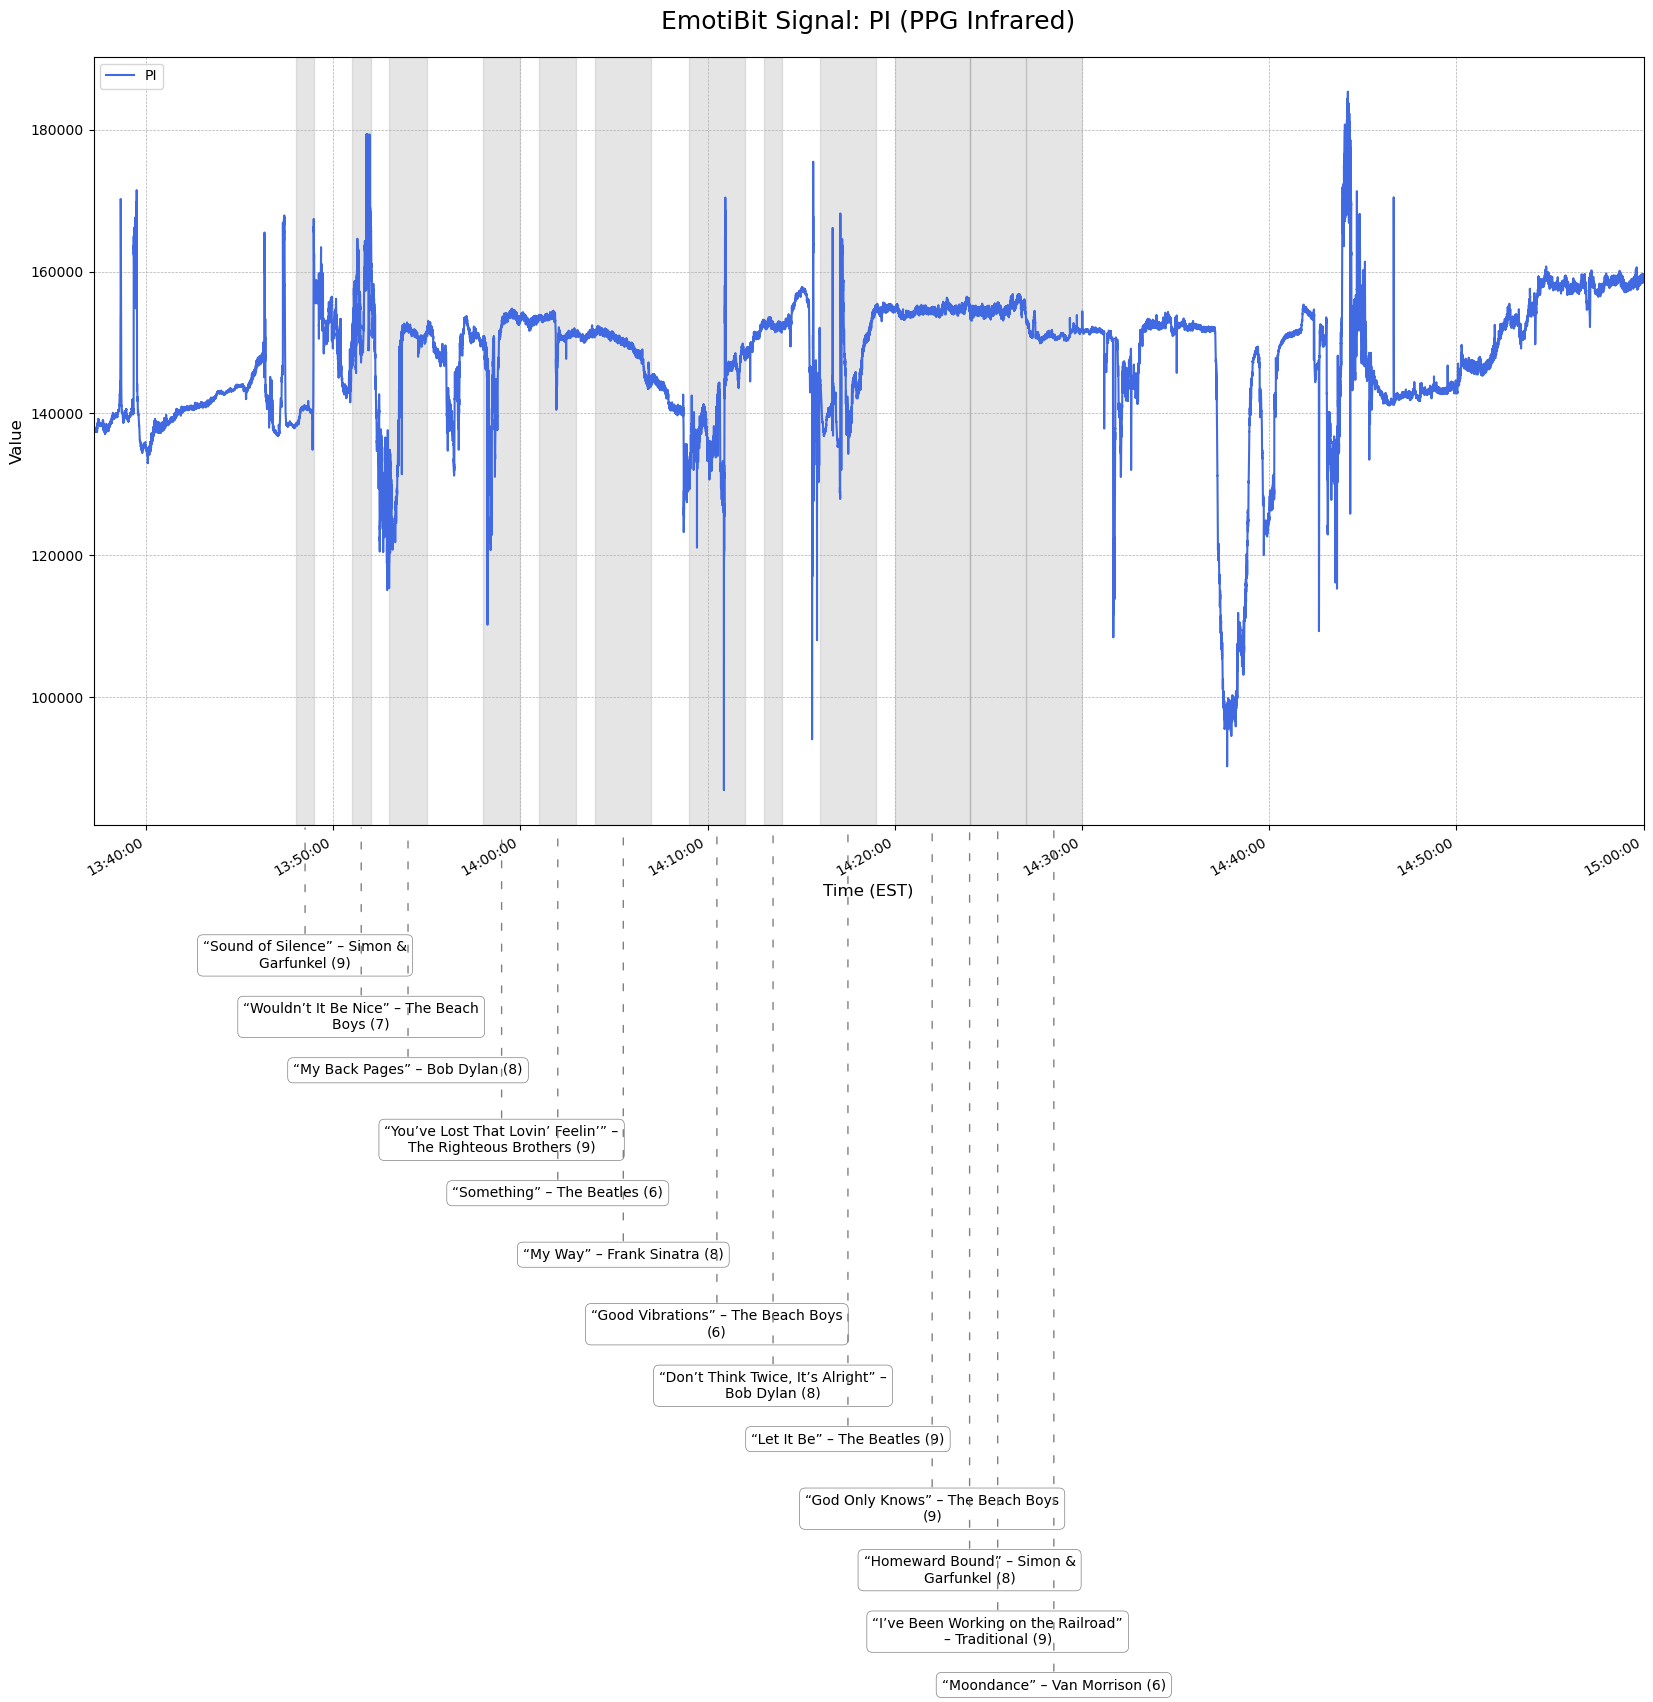

  - Plot saved to: ./July 16 Afternoon MB 000370/plots/PR_plot.png


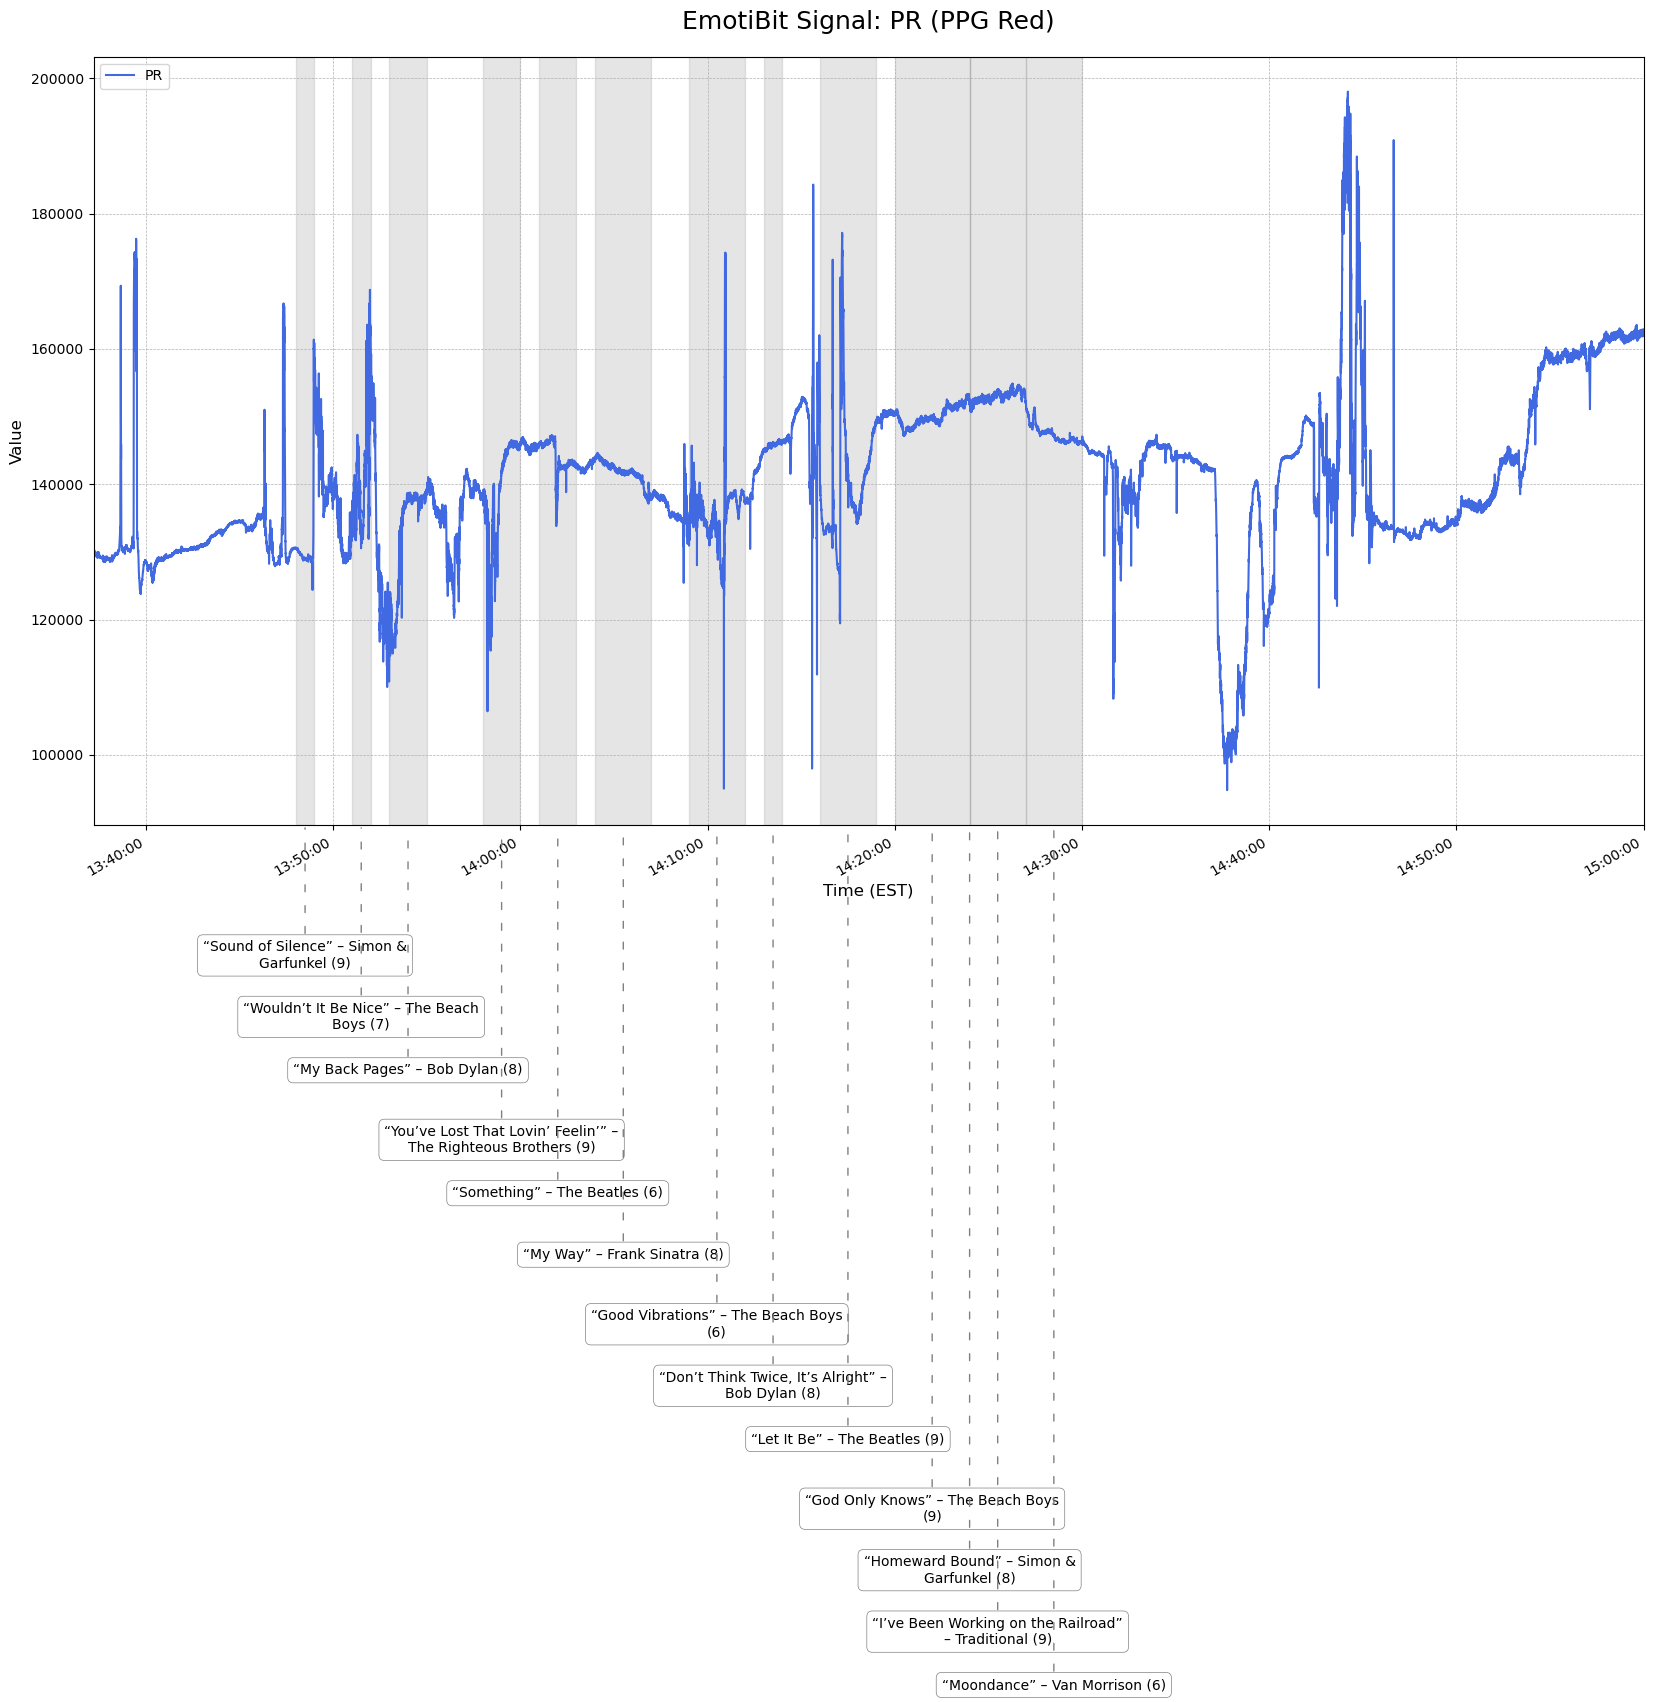

In [ ]:
# Import textwrap for handling long song titles
import textwrap

# Dictionary for human-readable signal names is defined in the configuration cell

def plot_and_save_signal(signal_name, df, music_schedule, channel_map, output_folder):
    """
    Plots a single signal with clean, non-overlapping music annotations and saves the figure.
    The figure height is dynamically adjusted, and the saved image is guaranteed not to be cropped.
    """
    if df.empty or df['est_time'].isnull().all():
        print(f"Data for signal '{signal_name}' is empty or has no valid timestamps. Skipping plot.")
        return

    # --- DYNAMIC FIGURE SIZING ---
    total_annotation_lines = 0
    plotted_songs_count = 0
    if music_schedule:
        min_time_data_check = df['est_time'].min()
        max_time_data_check = df['est_time'].max()
        for start, end, song in music_schedule:
            if not (start > max_time_data_check or end < min_time_data_check):
                plotted_songs_count += 1
                total_annotation_lines += len(textwrap.wrap(song, width=35))
    
    base_height = 5
    extra_height_per_line = 0.3 
    dynamic_height = base_height + (total_annotation_lines * extra_height_per_line)
    
    fig, ax = plt.subplots(figsize=(FIGURE_SIZE[0], dynamic_height))
    
    ax.plot(df['est_time'], df['value'], label=signal_name, color='royalblue', linewidth=1.5)

    min_time_data = df['est_time'].min()
    max_time_data = df['est_time'].max()
    ax.set_xlim(min_time_data, max_time_data)
    
    if music_schedule and plotted_songs_count > 0:
        y_level_start = -0.15
        y_level_step = -0.08
        stagger_level = 0
        
        for start, end, song in music_schedule:
            if start > max_time_data or end < min_time_data:
                continue

            # Set zorder of the background span to 0, the lowest layer.
            ax.axvspan(start, end, color=ANNOTATION_BACKGROUND_COLOR, alpha=ANNOTATION_ALPHA, zorder=0)
            
            annotation_x_position = start + (end - start) / 2
            
            if annotation_x_position < min_time_data: annotation_x_position = min_time_data
            if annotation_x_position > max_time_data: annotation_x_position = max_time_data

            y_level_for_text = y_level_start + (stagger_level * y_level_step)
            
            wrapped_song = textwrap.fill(song, width=35)
            
            # Draw the dashed line first, with zorder=1
            ax.annotate(
                '', 
                xy=(annotation_x_position, 0),
                xycoords=('data', 'axes fraction'),
                xytext=(annotation_x_position, y_level_for_text),
                textcoords=('data', 'axes fraction'),
                arrowprops=dict(arrowstyle="-", linestyle=(0, (5, 10)), color='gray', shrinkA=5, zorder=1)
            )
            
            # Then draw the text annotation on top, with zorder=2
            ax.annotate(
                wrapped_song, 
                xy=(annotation_x_position, y_level_for_text),
                xycoords=('data', 'axes fraction'),
                ha='center', 
                va='top',
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", lw=0.5, zorder=2)
            )
            
            stagger_level += 1

    # Use the CHANNELS dictionary for the title
    full_signal_name = channel_map.get(signal_name, signal_name)
    ax.set_title(f'EmotiBit Signal: {signal_name} ({full_signal_name})', fontsize=18, pad=20)
    
    ax.set_xlabel('Time (EST)', fontsize=12)
    ax.set_ylabel(f'Value', fontsize=12)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5)
    ax.legend(loc='upper left')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S', tz='US/Eastern'))
    fig.autofmt_xdate()
    
    # --- Save the Figure --- 
    output_filename = f"{signal_name}_plot.png"
    full_output_path = os.path.join(output_folder, output_filename)
    
    # Use bbox_inches='tight' to ensure all artists (like the song labels)
    # are included in the saved image.
    fig.savefig(full_output_path, dpi=150, bbox_inches='tight', pad_inches=0.1)
    print(f"  - Plot saved to: {full_output_path}")

    plt.show()

# --- Execute Plotting and Saving --- #
if not emotibit_data:
    print("\nExecution finished. No data was loaded, so no plots were generated.")
else:
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)
    print(f"\n--- Generating and Saving {len(emotibit_data)} Plots to '{OUTPUT_FOLDER}' ---\n")
    for signal, df in emotibit_data.items():
        plot_and_save_signal(signal, df, music_schedule, CHANNELS, OUTPUT_FOLDER)
    print("\n--- All plots have been generated and saved --- ")